In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

# Pre-processing, model selection and tuning techniques
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics



# Algorithms - Supervised Learning - classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Additional classifiers per project instructions
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

# Explainability tools per project instructions
import shap
from lime import lime_tabular
# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option("display.precision", 2)
warnings.filterwarnings('ignore')
%matplotlib inline



In [7]:
# Load the datasets
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Load datasets
print("Loading datasets...")
train_data = pd.read_csv('adult.data', header=None, names=column_names, 
                         na_values=' ?', skipinitialspace=True)
test_data = pd.read_csv('adult.test', header=None, names=column_names, 
                        na_values=' ?', skipinitialspace=True, skiprows=1)  # Skip first row which contains header

# Fix target format in test data (remove dot)
test_data['income'] = test_data['income'].str.replace('.', '')

# Display dataset information
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print("\nTraining data preview:")
print(train_data.head())


Loading datasets...
Training data shape: (32561, 15)
Test data shape: (16281, 15)

Training data preview:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0     

In [8]:
# Check for ? characters in the dataset 
for col in train_data.select_dtypes(include=['object']).columns:
    print(f"Column {col} has {(train_data[col] == ' ?').sum() + (train_data[col] == '?').sum()} '?' values")

for col in test_data.select_dtypes(include=['object']).columns:
    print(f"Column {col} has {(test_data[col] == ' ?').sum() + (test_data[col] == '?').sum()} '?' values")

Column workclass has 1836 '?' values
Column education has 0 '?' values
Column marital-status has 0 '?' values
Column occupation has 1843 '?' values
Column relationship has 0 '?' values
Column race has 0 '?' values
Column sex has 0 '?' values
Column native-country has 583 '?' values
Column income has 0 '?' values
Column workclass has 963 '?' values
Column education has 0 '?' values
Column marital-status has 0 '?' values
Column occupation has 966 '?' values
Column relationship has 0 '?' values
Column race has 0 '?' values
Column sex has 0 '?' values
Column native-country has 274 '?' values
Column income has 0 '?' values


In [9]:
# Replace ? and ' ?' with NaN in all object columns
for dataset in [train_data, test_data]:
    for col in dataset.select_dtypes(include=['object']).columns:
        # Replace both formats of question mark with NaN
        dataset[col] = dataset[col].replace(['?', ' ?'], np.nan)

# Verify the fix
print("\n--- After fixing ? values ---")
missing_train = pd.DataFrame({'sum_missing': train_data.isnull().sum()})
missing_test = pd.DataFrame({'sum_missing': test_data.isnull().sum()})
print("Training data missing values:")
print(missing_train[missing_train['sum_missing'] > 0])
print("\nTest data missing values:")
print(missing_test[missing_test['sum_missing'] > 0])


--- After fixing ? values ---
Training data missing values:
                sum_missing
workclass              1836
occupation             1843
native-country          583

Test data missing values:
                sum_missing
workclass               963
occupation              966
native-country          274


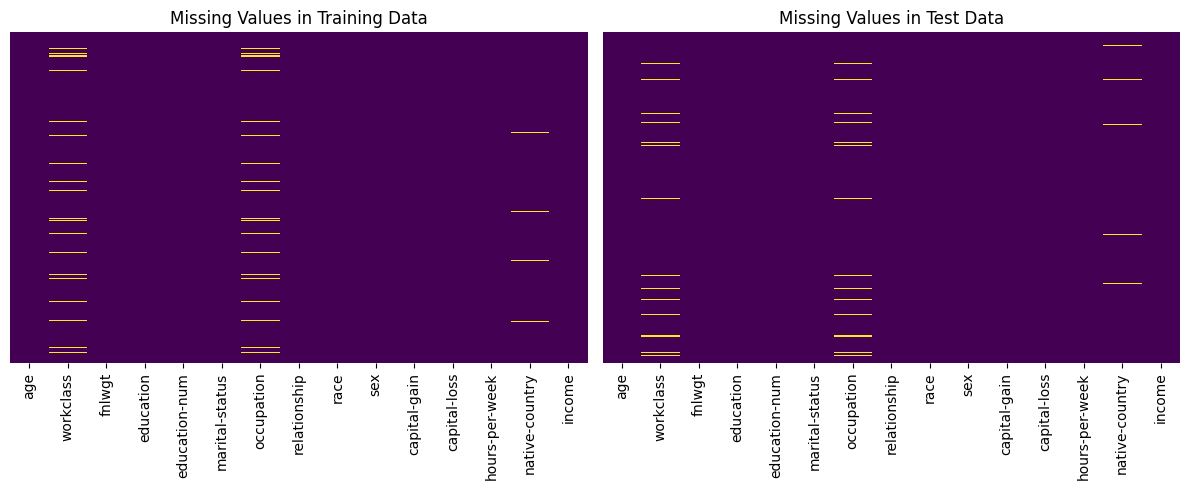

In [10]:
# Visualize missing values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values in Training Data')

plt.subplot(1, 2, 2)
sns.heatmap(test_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values in Test Data')
plt.tight_layout()
plt.show()

In [11]:
# Impute missing values - run this before splitting the data
# For categorical features - impute with most frequent value
for col in train_data.select_dtypes(include=['object']).columns:
    if train_data[col].isnull().sum() > 0:
        most_frequent = train_data[col].mode()[0]
        train_data[col].fillna(most_frequent, inplace=True)
        test_data[col].fillna(most_frequent, inplace=True)
        print(f"Imputed missing values in {col} with '{most_frequent}'")

# For numerical features - impute with median
for col in train_data.select_dtypes(include=['number']).columns:
    if train_data[col].isnull().sum() > 0:
        median_value = train_data[col].median()
        train_data[col].fillna(median_value, inplace=True)
        test_data[col].fillna(median_value, inplace=True)
        print(f"Imputed missing values in {col} with median: {median_value}")

# Verify all missing values are handled
print("\n--- After imputation ---")
print("Any missing values in training data:", train_data.isnull().any().any())
print("Any missing values in test data:", test_data.isnull().any().any())

Imputed missing values in workclass with 'Private'
Imputed missing values in occupation with 'Prof-specialty'
Imputed missing values in native-country with 'United-States'

--- After imputation ---
Any missing values in training data: False
Any missing values in test data: False


In [12]:
# Data description & overview
print("\n--- Data Types Information ---")
train_data.info()


--- Data Types Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [13]:
# Check for missing values
print("\n--- Missing Values ---")
missing_train = pd.DataFrame({'sum_missing': train_data.isnull().sum()})
missing_test = pd.DataFrame({'sum_missing': test_data.isnull().sum()})
print("Training data missing values:")
print(missing_train[missing_train['sum_missing'] > 0])
print("\nTest data missing values:")
print(missing_test[missing_test['sum_missing'] > 0])


--- Missing Values ---
Training data missing values:
Empty DataFrame
Columns: [sum_missing]
Index: []

Test data missing values:
Empty DataFrame
Columns: [sum_missing]
Index: []


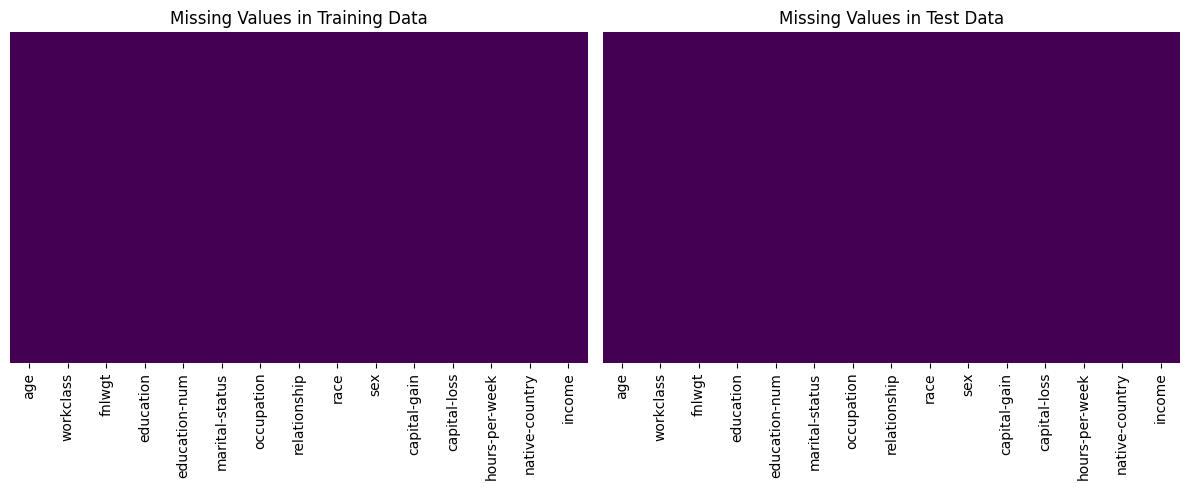

In [14]:
# Visualize missing values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values in Training Data')

plt.subplot(1, 2, 2)
sns.heatmap(test_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values in Test Data')
plt.tight_layout()
plt.show()

In [15]:
# Target variable distribution
print("\n--- Target Variable Distribution ---")
print("Training data target distribution:")
train_target_dist = train_data['income'].value_counts(normalize=True) * 100
print(train_target_dist)



--- Target Variable Distribution ---
Training data target distribution:
income
<=50K    75.92
>50K     24.08
Name: proportion, dtype: float64


Text(0, 0.5, 'Count')

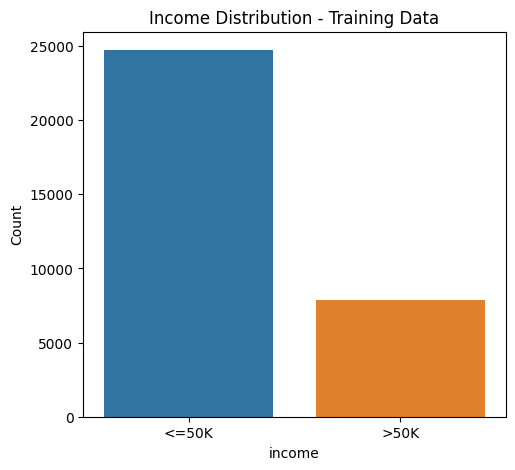

In [16]:
# Visualize target distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='income',hue='income', data=train_data)
plt.title('Income Distribution - Training Data')
plt.ylabel('Count')

In [17]:
# Remove fnlwgt as it's a census weighting feature, not predictive of income
print("\n--- Removing fnlwgt column ---")
train_data = train_data.drop('fnlwgt', axis=1)
test_data = test_data.drop('fnlwgt', axis=1)


--- Removing fnlwgt column ---


In [18]:
# EDA - Numerical features
numerical_features = ['age','education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
print("\n--- Numerical Features Summary ---")
print(train_data[numerical_features].describe())


--- Numerical Features Summary ---
            age  education-num  capital-gain  capital-loss  hours-per-week
count  32561.00       32561.00      32561.00      32561.00        32561.00
mean      38.58          10.08       1077.65         87.30           40.44
std       13.64           2.57       7385.29        402.96           12.35
min       17.00           1.00          0.00          0.00            1.00
25%       28.00           9.00          0.00          0.00           40.00
50%       37.00          10.00          0.00          0.00           40.00
75%       48.00          12.00          0.00          0.00           45.00
max       90.00          16.00      99999.00       4356.00           99.00


Text(0.5, 1.0, 'Age Distribution by Income')

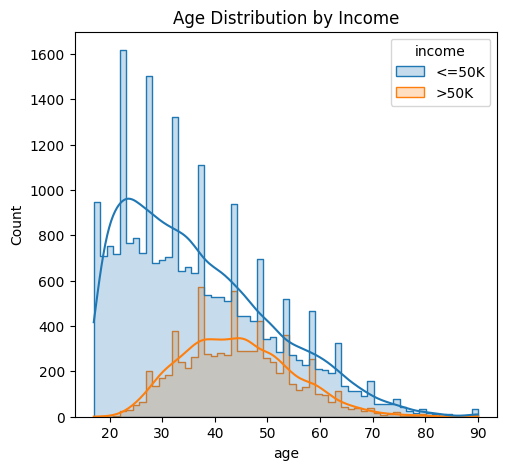

In [19]:
# Visualize age distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_data, x='age', hue='income', kde=True, element='step')
plt.title('Age Distribution by Income')

Text(0.5, 1.0, 'Hours per Week Distribution by Income')

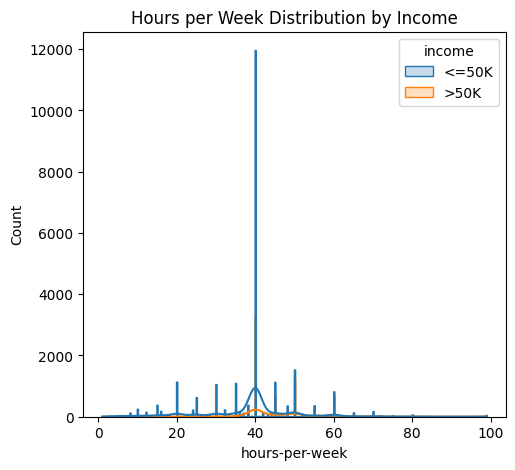

In [20]:
# Visualize hours-per-week distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_data, x='hours-per-week', hue='income', kde=True, element='step')
plt.title('Hours per Week Distribution by Income')

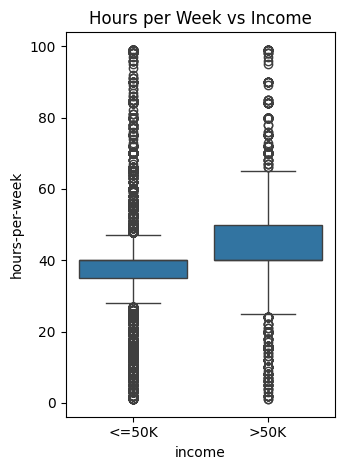

In [21]:
plt.subplot(1, 2, 2)
sns.boxplot(data=train_data, x='income', y='hours-per-week')
plt.title('Hours per Week vs Income')
plt.tight_layout()
plt.show()

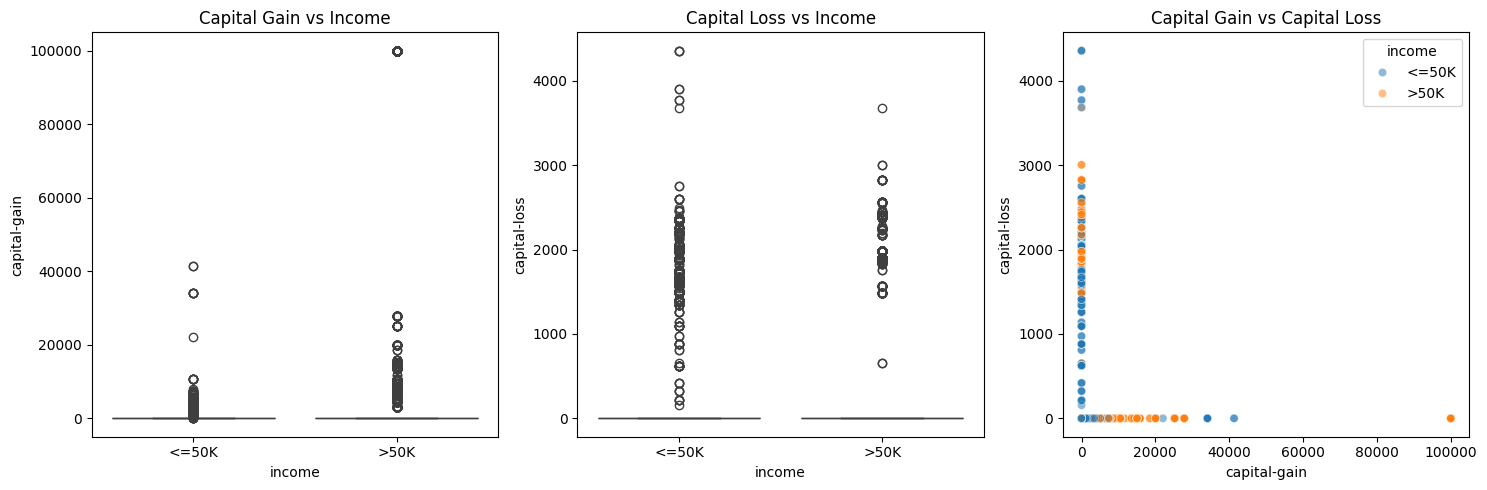

In [22]:
# Visualize capital-gain and capital-loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=train_data, x='income', y='capital-gain')
plt.title('Capital Gain vs Income')
plt.subplot(1, 3, 2)
sns.boxplot(data=train_data, x='income', y='capital-loss')
plt.title('Capital Loss vs Income')
plt.subplot(1, 3, 3)
sns.scatterplot(data=train_data, x='capital-gain', y='capital-loss', hue='income', alpha=0.5)
plt.title('Capital Gain vs Capital Loss')
plt.tight_layout()
plt.show()

In [23]:
# EDA - Categorical features
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']

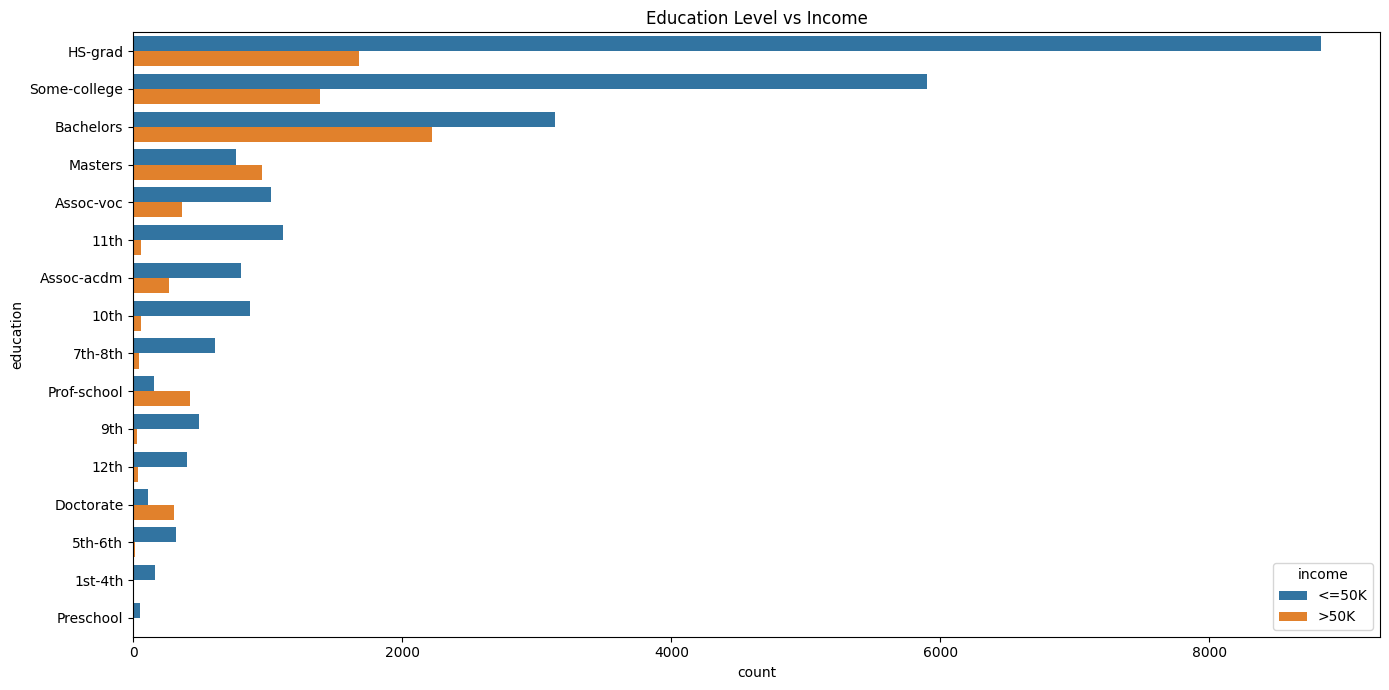

In [24]:
# Education vs Income
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='education', hue='income', order=train_data['education'].value_counts().index)
plt.title('Education Level vs Income')
plt.tight_layout()
plt.show()

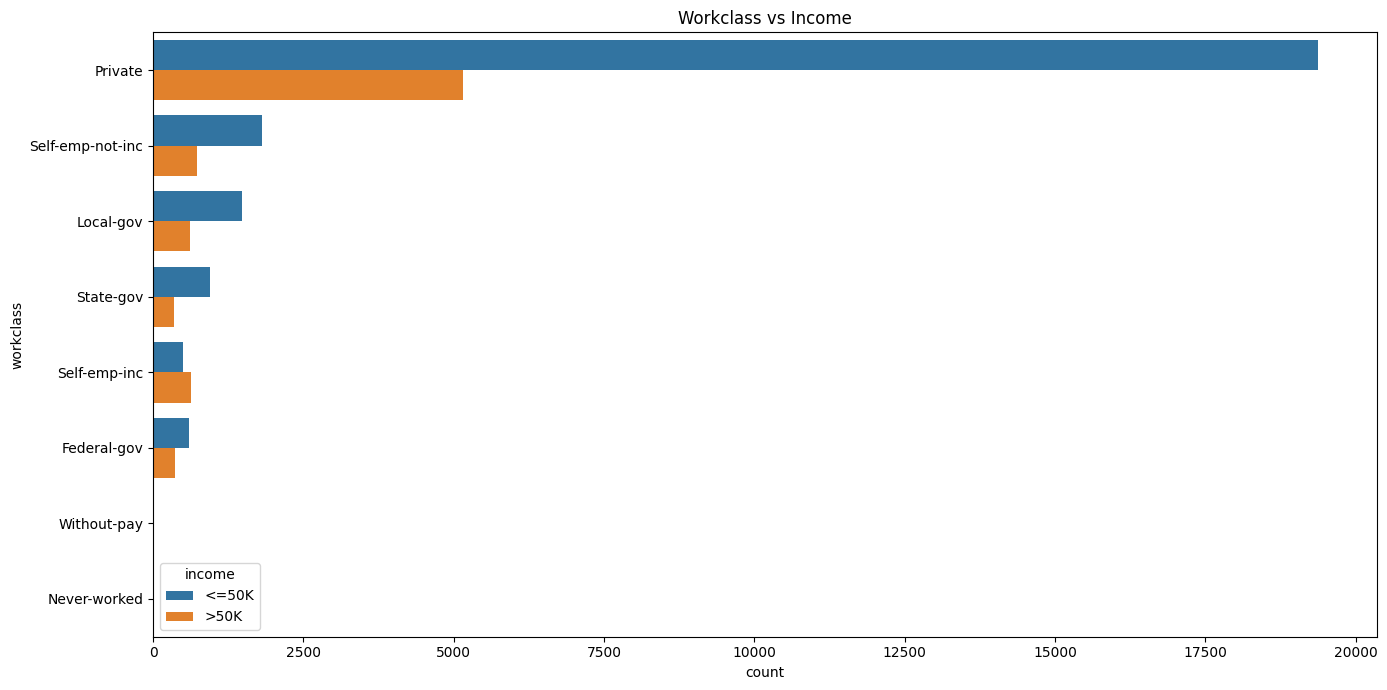

In [25]:
# Workclass vs Income
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='workclass', hue='income', order=train_data['workclass'].value_counts().index)
plt.title('Workclass vs Income')
plt.tight_layout()
plt.show()

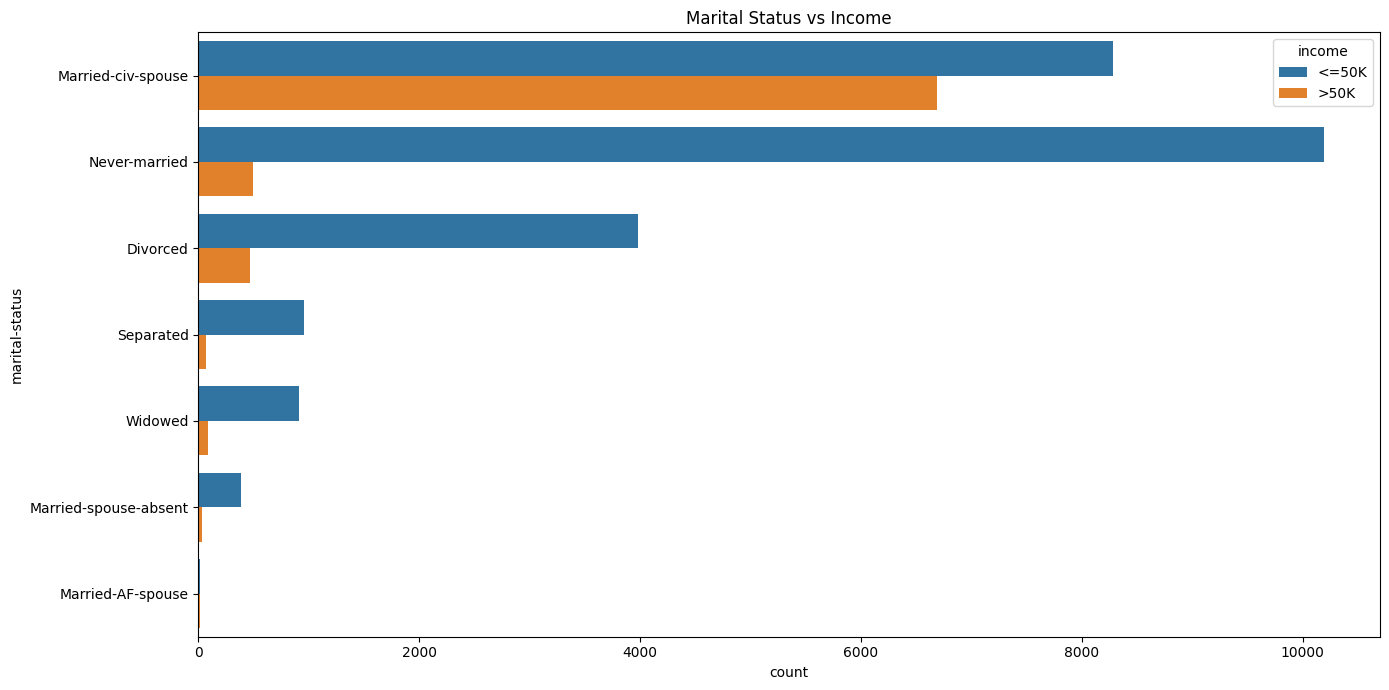

In [26]:
# Marital Status vs Income
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='marital-status', hue='income', order=train_data['marital-status'].value_counts().index)
plt.title('Marital Status vs Income')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Gender vs Income (Count)')

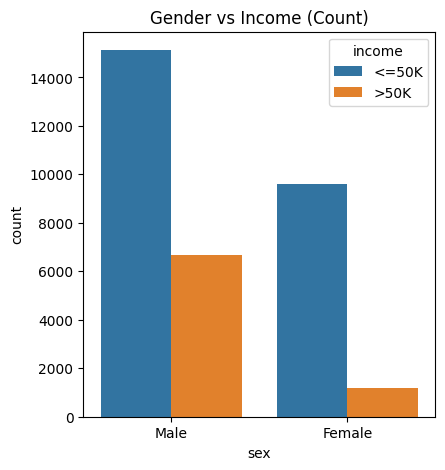

In [27]:

# Gender vs Income
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=train_data, x='sex', hue='income')
plt.title('Gender vs Income (Count)')

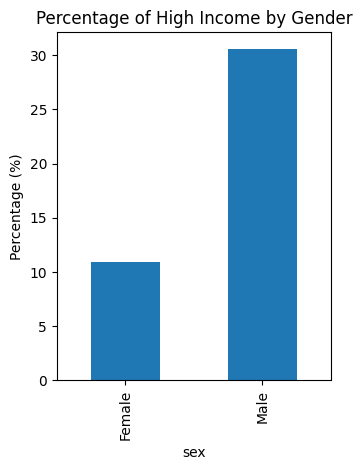

In [28]:
# Calculate percentage of high income by gender
income_by_gender = pd.crosstab(train_data['sex'], train_data['income'], normalize='index') * 100
plt.subplot(1, 2, 2)
income_by_gender['>50K'].plot(kind='bar')
plt.title('Percentage of High Income by Gender')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

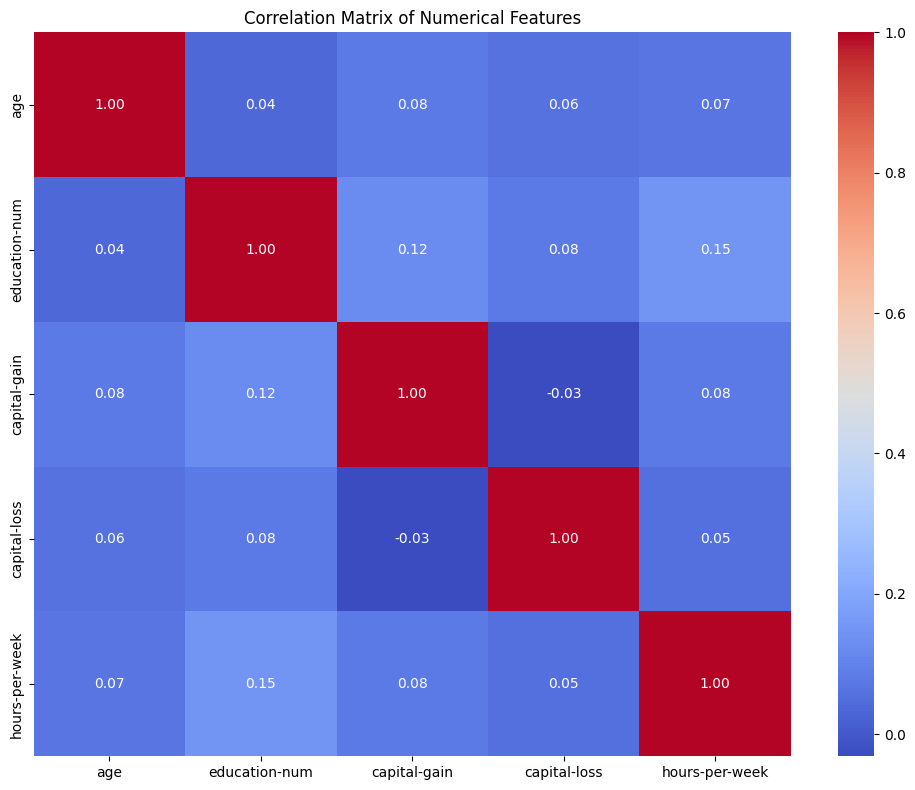

In [29]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
correlation = train_data[numerical_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [30]:
# Feature Engineering and Feature Creation

# Create a feature for income-related factors
train_data['income_ratio'] = train_data['capital-gain'] / (train_data['capital-loss'] + 1) 
test_data['income_ratio'] = test_data['capital-gain'] / (test_data['capital-loss'] + 1)

# Create work-status feature
train_data['work_intensity'] = train_data['hours-per-week'] / 40
test_data['work_intensity'] = test_data['hours-per-week'] / 40

# Create education to age ratio (education efficiency)
train_data['education_efficiency'] = train_data['education-num'] / train_data['age']
test_data['education_efficiency'] = test_data['education-num'] / test_data['age']

# Split into features and target
X = train_data.drop('income', axis=1)
y = train_data['income']
X_test_final = test_data.drop('income', axis=1)
y_test_final = test_data['income']

print("X dimensions: ", X.shape)
print("y dimensions: ", y.shape)
print("X_test_final dimensions: ", X_test_final.shape)

# Check target distribution
print("\nTarget Distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True) * 100)

X dimensions:  (32561, 16)
y dimensions:  (32561,)
X_test_final dimensions:  (16281, 16)

Target Distribution:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64
income
<=50K    75.92
>50K     24.08
Name: proportion, dtype: float64


In [31]:
# Train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=1)

print('Shape of X_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of X_test and y_test: ', X_test.shape, y_test.shape)

Shape of X_train and y_train:  (22792, 16) (22792,)
Shape of X_test and y_test:  (9769, 16) (9769,)


In [32]:
# Check missing values
print("\n--- Missing Values After Split ---")
print("Training data missing values:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("\nTest data missing values:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])


--- Missing Values After Split ---
Training data missing values:
Series([], dtype: int64)

Test data missing values:
Series([], dtype: int64)


In [33]:
# One-hot encoding for categorical features
X_train_ohe = pd.get_dummies(X_train[categorical_features], dtype=int)
X_train = X_train.drop(categorical_features, axis=1)
X_train = X_train.join(X_train_ohe)

X_test_ohe = pd.get_dummies(X_test[categorical_features], dtype=int)
X_test = X_test.drop(categorical_features, axis=1)
X_test = X_test.join(X_test_ohe)

X_test_final_ohe = pd.get_dummies(X_test_final[categorical_features], dtype=int)
X_test_final = X_test_final.drop(categorical_features, axis=1)
X_test_final = X_test_final.join(X_test_final_ohe)


In [34]:
# Ensure consistent columns between train and test sets
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

extra_cols = set(X_test.columns) - set(X_train.columns)
for col in extra_cols:
    X_test = X_test.drop([col], axis=1)
    
missing_cols = set(X_train.columns) - set(X_test_final.columns)
for col in missing_cols:
    X_test_final[col] = 0
    
extra_cols = set(X_test_final.columns) - set(X_train.columns)
for col in extra_cols:
    X_test_final = X_test_final.drop([col], axis=1)

In [35]:
# Ensure columns are in same order
X_test = X_test[X_train.columns]
X_test_final = X_test_final[X_train.columns]

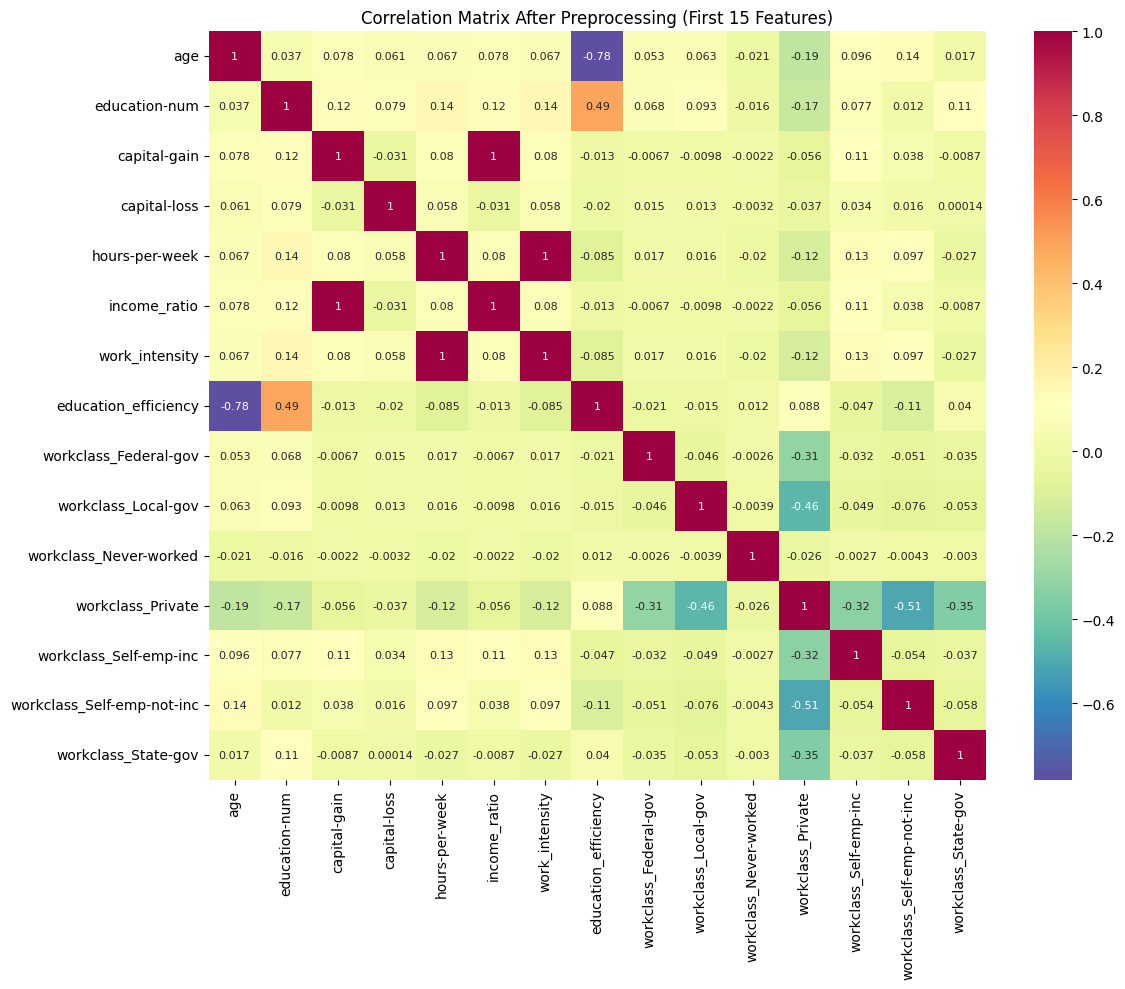

In [36]:
# Correlation matrix after preprocessing
plt.figure(figsize=(12, 10))
corr_matrix = X_train.iloc[:, :15].corr()  # First 15 columns
sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 8}, cmap="Spectral_r")
plt.title('Correlation Matrix After Preprocessing (First 15 Features)')
plt.tight_layout()
plt.show()

In [37]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test_final_scaled = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns)


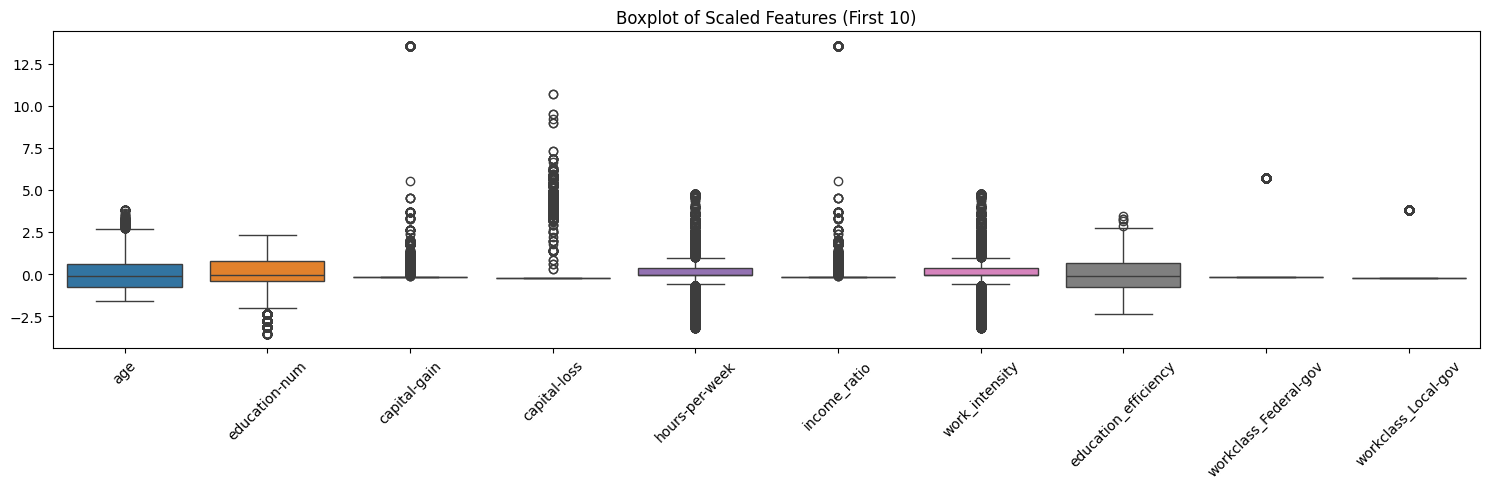

In [38]:
# Visualize scaled data distribution
plt.figure(figsize=(15, 5))
sns.boxplot(data=X_train_scaled.iloc[:, :10])  # First 10 columns
plt.title('Boxplot of Scaled Features (First 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
# Create DataFrame to store classifier results
clf_results = pd.DataFrame([])

In [40]:
# 1. KNN Classifier - Benchmark
print("\n--- KNN Benchmark ---")
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print('Accuracy for KNN:', round(metrics.accuracy_score(y_test, y_pred_knn), 3))
print('F1 Score for KNN:', round(metrics.f1_score(y_test, y_pred_knn, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_knn))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Benchmark KNN'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_knn), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_knn, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_knn, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_knn, pos_label='>50K'), 3)]
})])


--- KNN Benchmark ---
Accuracy for KNN: 0.826
F1 Score for KNN: 0.616
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.89      7417
        >50K       0.66      0.58      0.62      2352

    accuracy                           0.83      9769
   macro avg       0.76      0.74      0.75      9769
weighted avg       0.82      0.83      0.82      9769



In [41]:
# KNN Hyperparameter Tuning
print("\n--- KNN Hyperparameter Tuning ---")
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), 
                       knn_param_grid, 
                       cv=5, 
                       scoring='f1',
                       verbose=1)

knn_grid.fit(X_train_scaled, y_train)
print("Best KNN parameters:", knn_grid.best_params_)

knn_opt = knn_grid.best_estimator_
y_pred_knn_opt = knn_opt.predict(X_test_scaled)

print('Accuracy for Optimized KNN:', round(metrics.accuracy_score(y_test, y_pred_knn_opt), 3))
print('F1 Score for Optimized KNN:', round(metrics.f1_score(y_test, y_pred_knn_opt, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_knn_opt))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Optimized KNN'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_knn_opt), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_knn_opt, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_knn_opt, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_knn_opt, pos_label='>50K'), 3)]
})])


--- KNN Hyperparameter Tuning ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Accuracy for Optimized KNN: 0.82
F1 Score for Optimized KNN: 0.611
              precision    recall  f1-score   support

       <=50K       0.87      0.89      0.88      7417
        >50K       0.64      0.59      0.61      2352

    accuracy                           0.82      9769
   macro avg       0.75      0.74      0.75      9769
weighted avg       0.82      0.82      0.82      9769



In [42]:
# 2. Random Forest - Benchmark
print("\n--- Random Forest Benchmark ---")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print('Accuracy for Random Forest:', round(metrics.accuracy_score(y_test, y_pred_rf), 3))
print('F1 Score for Random Forest:', round(metrics.f1_score(y_test, y_pred_rf, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_rf))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Benchmark Random Forest'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_rf), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_rf, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_rf, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_rf, pos_label='>50K'), 3)]
})])


--- Random Forest Benchmark ---
Accuracy for Random Forest: 0.85
F1 Score for Random Forest: 0.663
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7417
        >50K       0.72      0.61      0.66      2352

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769



In [43]:
# Random Forest Hyperparameter Tuning
print("\n--- Random Forest Hyperparameter Tuning ---")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                            rf_param_grid, 
                            n_iter=20,
                            cv=5, 
                            scoring='f1',
                            verbose=1,
                            random_state=42)

rf_grid.fit(X_train_scaled, y_train)
print("Best Random Forest parameters:", rf_grid.best_params_)

rf_opt = rf_grid.best_estimator_
y_pred_rf_opt = rf_opt.predict(X_test_scaled)

print('Accuracy for Optimized Random Forest:', round(metrics.accuracy_score(y_test, y_pred_rf_opt), 3))
print('F1 Score for Optimized Random Forest:', round(metrics.f1_score(y_test, y_pred_rf_opt, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_rf_opt))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Optimized Random Forest'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_rf_opt), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_rf_opt, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_rf_opt, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_rf_opt, pos_label='>50K'), 3)]
})])


--- Random Forest Hyperparameter Tuning ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Accuracy for Optimized Random Forest: 0.861
F1 Score for Optimized Random Forest: 0.667
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7417
        >50K       0.79      0.58      0.67      2352

    accuracy                           0.86      9769
   macro avg       0.83      0.76      0.79      9769
weighted avg       0.86      0.86      0.85      9769



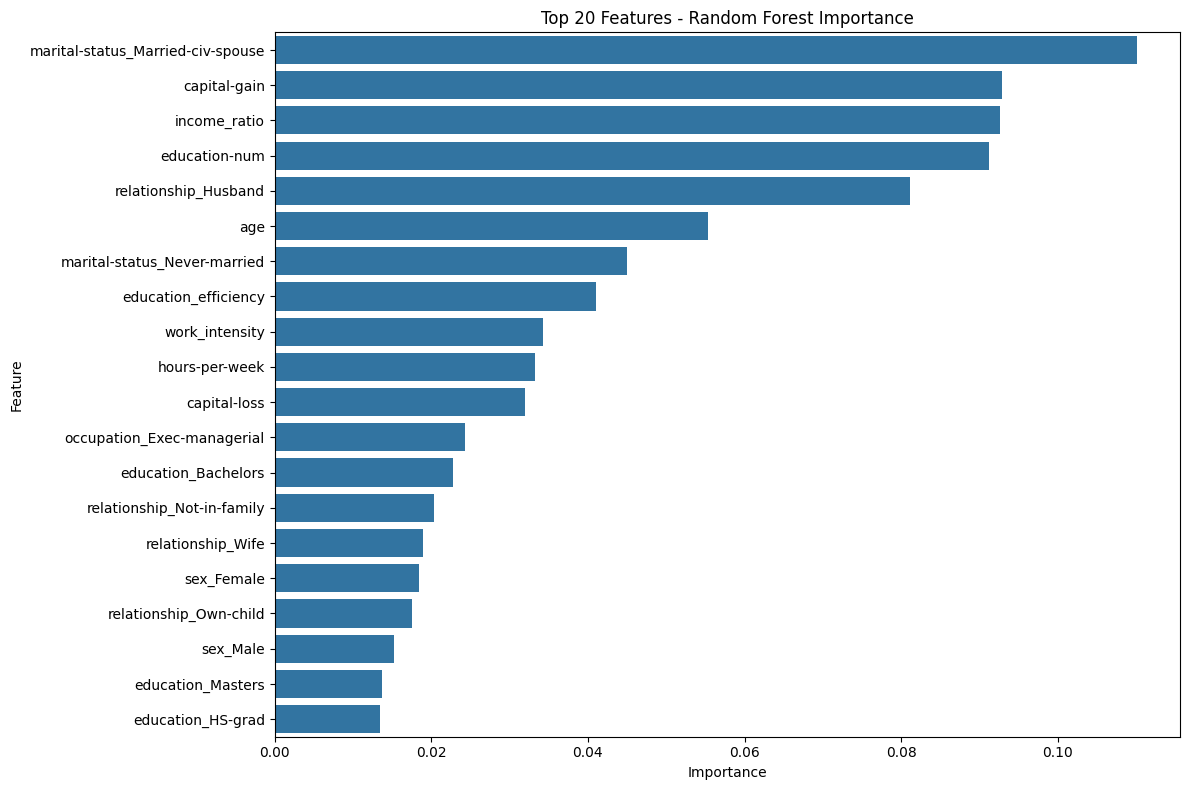

In [44]:
# Plot feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_opt.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Features - Random Forest Importance')
plt.tight_layout()
plt.show()

In [45]:
# 3. SVM - Benchmark
print("\n--- SVM Benchmark ---")
svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print('Accuracy for SVM:', round(metrics.accuracy_score(y_test, y_pred_svm), 3))
print('F1 Score for SVM:', round(metrics.f1_score(y_test, y_pred_svm, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_svm))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Benchmark SVM'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_svm), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_svm, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_svm, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_svm, pos_label='>50K'), 3)]
})])


--- SVM Benchmark ---
Accuracy for SVM: 0.848
F1 Score for SVM: 0.646
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      7417
        >50K       0.73      0.58      0.65      2352

    accuracy                           0.85      9769
   macro avg       0.80      0.76      0.77      9769
weighted avg       0.84      0.85      0.84      9769



In [46]:
# SVM Hyperparameter Tuning
print("\n--- SVM Hyperparameter Tuning ---")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm_grid = RandomizedSearchCV(SVC(random_state=42), 
                             svm_param_grid, 
                             n_iter=10,  # Number of parameter settings sampled
                             cv=5, 
                             scoring='f1',
                             verbose=1,
                             random_state=42)

svm_grid.fit(X_train_scaled, y_train)
print("Best SVM parameters:", svm_grid.best_params_)

svm_opt = svm_grid.best_estimator_
y_pred_svm_opt = svm_opt.predict(X_test_scaled)

print('Accuracy for Optimized SVM:', round(metrics.accuracy_score(y_test, y_pred_svm_opt), 3))
print('F1 Score for Optimized SVM:', round(metrics.f1_score(y_test, y_pred_svm_opt, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_svm_opt))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Optimized SVM'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_svm_opt), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_svm_opt, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_svm_opt, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_svm_opt, pos_label='>50K'), 3)]
})])


--- SVM Hyperparameter Tuning ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best SVM parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Accuracy for Optimized SVM: 0.845
F1 Score for Optimized SVM: 0.647
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      7417
        >50K       0.72      0.59      0.65      2352

    accuracy                           0.84      9769
   macro avg       0.80      0.76      0.77      9769
weighted avg       0.84      0.84      0.84      9769



In [47]:
# 4. XGBoost - First additional model per project requirements
print("\n--- XGBoost Benchmark ---")
# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train_encoded)
y_pred_xgb = label_encoder.inverse_transform(xgb_model.predict(X_test_scaled))

print('Accuracy for XGBoost:', round(metrics.accuracy_score(y_test, y_pred_xgb), 3))
print('F1 Score for XGBoost:', round(metrics.f1_score(y_test, y_pred_xgb, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_xgb))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Benchmark XGBoost'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_xgb), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_xgb, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_xgb, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_xgb, pos_label='>50K'), 3)]
})])


--- XGBoost Benchmark ---
Accuracy for XGBoost: 0.872
F1 Score for XGBoost: 0.713
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      7417
        >50K       0.77      0.66      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769



In [48]:
# XGBoost Hyperparameter Tuning
print("\n--- XGBoost Hyperparameter Tuning ---")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Use encoded target variable for training
xgb_grid = RandomizedSearchCV(xgb.XGBClassifier(random_state=42), 
                             xgb_param_grid, 
                             n_iter=20,
                             cv=5, 
                             scoring='f1',
                             verbose=1,
                             random_state=42)

xgb_grid.fit(X_train_scaled, y_train_encoded)
print("Best XGBoost parameters:", xgb_grid.best_params_)

xgb_opt = xgb_grid.best_estimator_
y_pred_xgb_opt_encoded = xgb_opt.predict(X_test_scaled)
y_pred_xgb_opt = label_encoder.inverse_transform(y_pred_xgb_opt_encoded)

print('Accuracy for Optimized XGBoost:', round(metrics.accuracy_score(y_test, y_pred_xgb_opt), 3))
print('F1 Score for Optimized XGBoost:', round(metrics.f1_score(y_test, y_pred_xgb_opt, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_xgb_opt))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Optimized XGBoost'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_xgb_opt), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_xgb_opt, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_xgb_opt, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_xgb_opt, pos_label='>50K'), 3)]
})])


--- XGBoost Hyperparameter Tuning ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
Accuracy for Optimized XGBoost: 0.871
F1 Score for Optimized XGBoost: 0.709
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      7417
        >50K       0.78      0.65      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



<Figure size 1200x800 with 0 Axes>

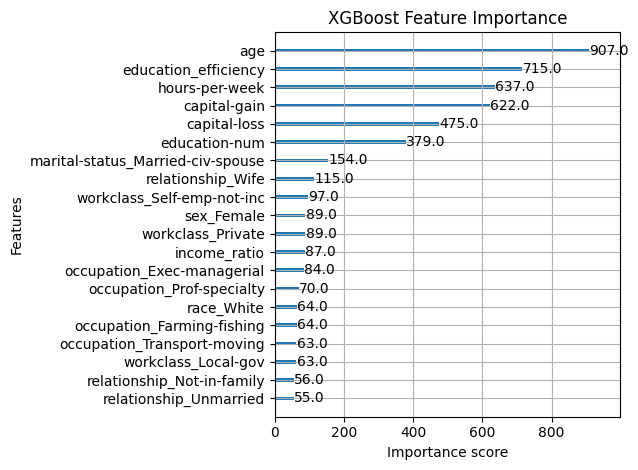

In [49]:
# Feature importance for XGBoost
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_opt, max_num_features=20)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [50]:
# 5. Gradient Boosting - Second additional model per project requirements
print("\n--- Gradient Boosting Benchmark ---")
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

print('Accuracy for Gradient Boosting:', round(metrics.accuracy_score(y_test, y_pred_gb), 3))
print('F1 Score for Gradient Boosting:', round(metrics.f1_score(y_test, y_pred_gb, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_gb))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Benchmark Gradient Boosting'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_gb), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_gb, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_gb, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_gb, pos_label='>50K'), 3)]
})])


--- Gradient Boosting Benchmark ---
Accuracy for Gradient Boosting: 0.865
F1 Score for Gradient Boosting: 0.685
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7417
        >50K       0.78      0.61      0.69      2352

    accuracy                           0.87      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.87      0.86      9769



In [51]:
# Gradient Boosting Hyperparameter Tuning
print("\n--- Gradient Boosting Hyperparameter Tuning ---")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                           gb_param_grid, 
                           n_iter=20,
                           cv=5, 
                           scoring='f1',
                           verbose=1,
                           random_state=42)

gb_grid.fit(X_train_scaled, y_train)
print("Best Gradient Boosting parameters:", gb_grid.best_params_)

gb_opt = gb_grid.best_estimator_
y_pred_gb_opt = gb_opt.predict(X_test_scaled)

print('Accuracy for Optimized Gradient Boosting:', round(metrics.accuracy_score(y_test, y_pred_gb_opt), 3))
print('F1 Score for Optimized Gradient Boosting:', round(metrics.f1_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_gb_opt))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Optimized Gradient Boosting'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_gb_opt), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3)]
})])


--- Gradient Boosting Hyperparameter Tuning ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Gradient Boosting parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.2}
Accuracy for Optimized Gradient Boosting: 0.868
F1 Score for Optimized Gradient Boosting: 0.705
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.91      7417
        >50K       0.76      0.66      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.86      0.87      0.86      9769



In [52]:
# Compare all models
print("\n--- Model Comparison ---")
clf_results = clf_results.sort_values(by='F1', ascending=False)
print(clf_results)


--- Model Comparison ---
                         Model  Accuracy    F1  Precision  Recall
0            Benchmark XGBoost      0.87  0.71       0.78    0.66
0            Optimized XGBoost      0.87  0.71       0.78    0.65
0  Optimized Gradient Boosting      0.87  0.70       0.76    0.66
0  Benchmark Gradient Boosting      0.86  0.69       0.78    0.61
0      Optimized Random Forest      0.86  0.67       0.79    0.58
0      Benchmark Random Forest      0.85  0.66       0.72    0.61
0                Optimized SVM      0.84  0.65       0.71    0.59
0                Benchmark SVM      0.85  0.65       0.73    0.58
0                Benchmark KNN      0.83  0.62       0.66    0.58
0                Optimized KNN      0.82  0.61       0.64    0.59


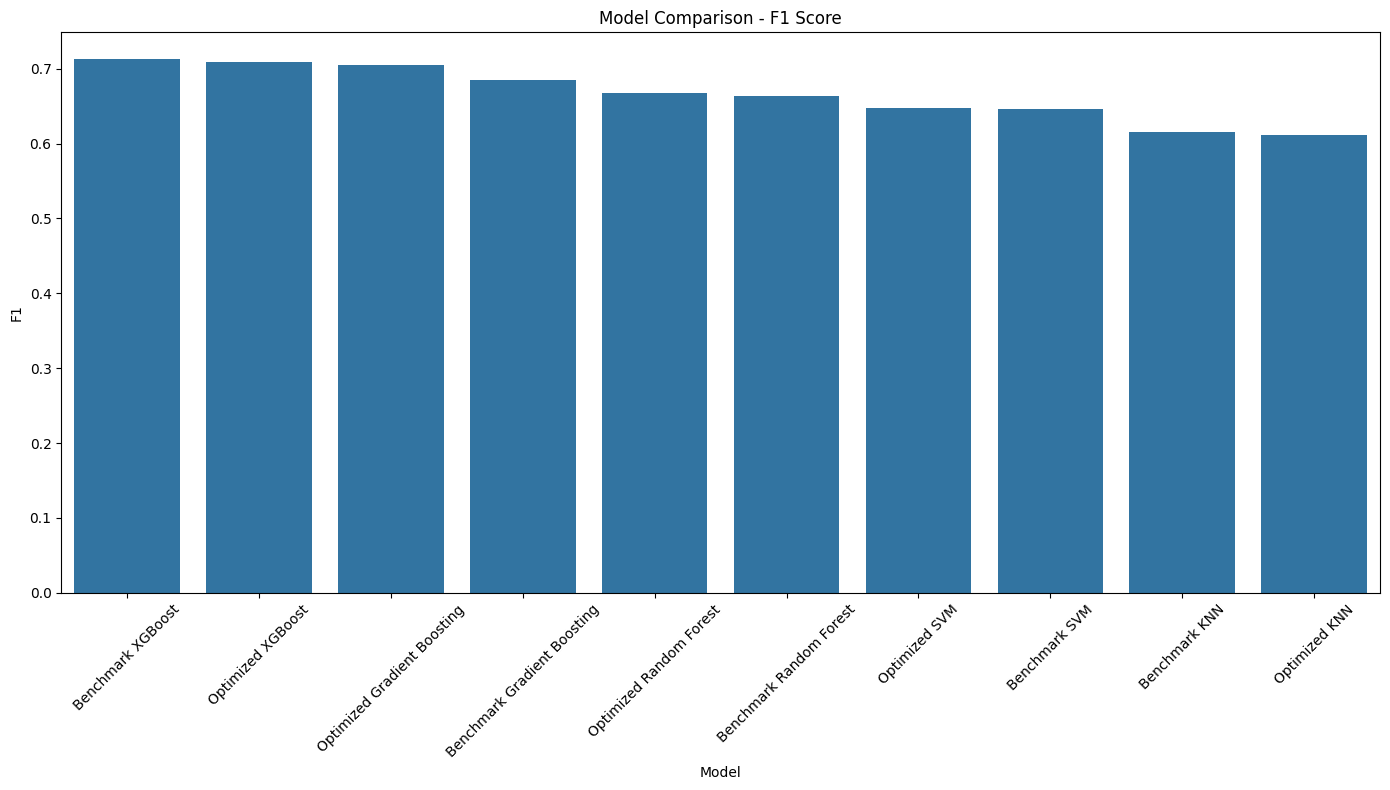

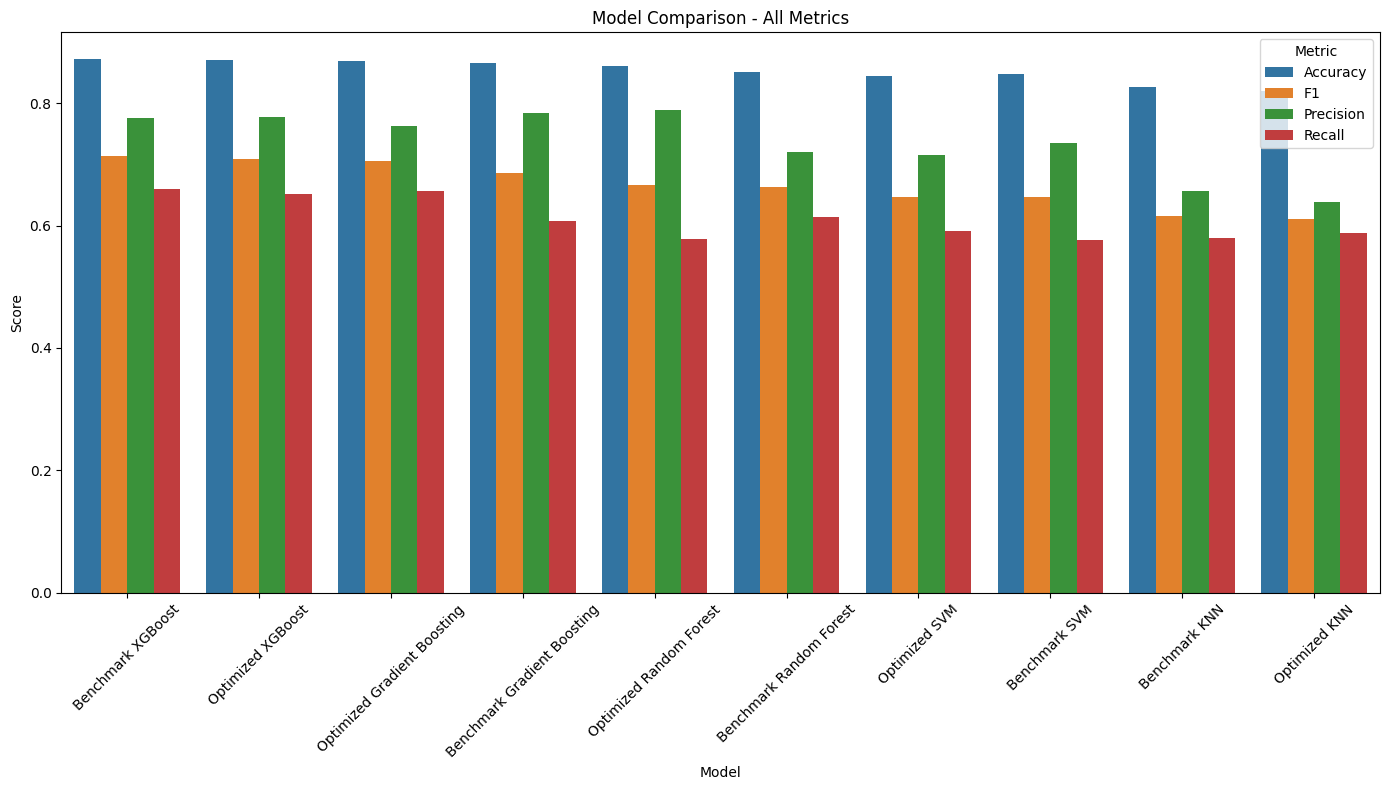

In [53]:
# Visualize model comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='F1', data=clf_results)
plt.title('Model Comparison - F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
clf_results_melted = pd.melt(clf_results, id_vars=['Model'], value_vars=metrics, 
                            var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=clf_results_melted)
plt.title('Model Comparison - All Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



--- Model Evaluation with Cross-Validation ---

Evaluating KNN with 5-fold cross-validation...

Evaluating Random Forest with 5-fold cross-validation...

Evaluating SVM with 5-fold cross-validation...

Evaluating XGBoost with 5-fold cross-validation...

--- Cross-Validation Results ---
           Model       Accuracy       F1 Score      Precision         Recall
0            KNN  0.815 ± 0.002  0.598 ± 0.006  0.628 ± 0.004  0.571 ± 0.012
1  Random Forest  0.861 ± 0.002  0.663 ± 0.006  0.796 ± 0.009  0.567 ± 0.008
2            SVM  0.845 ± 0.002  0.644 ± 0.004  0.720 ± 0.011  0.582 ± 0.007
3        XGBoost  0.871 ± 0.004  0.708 ± 0.009  0.782 ± 0.009  0.647 ± 0.014


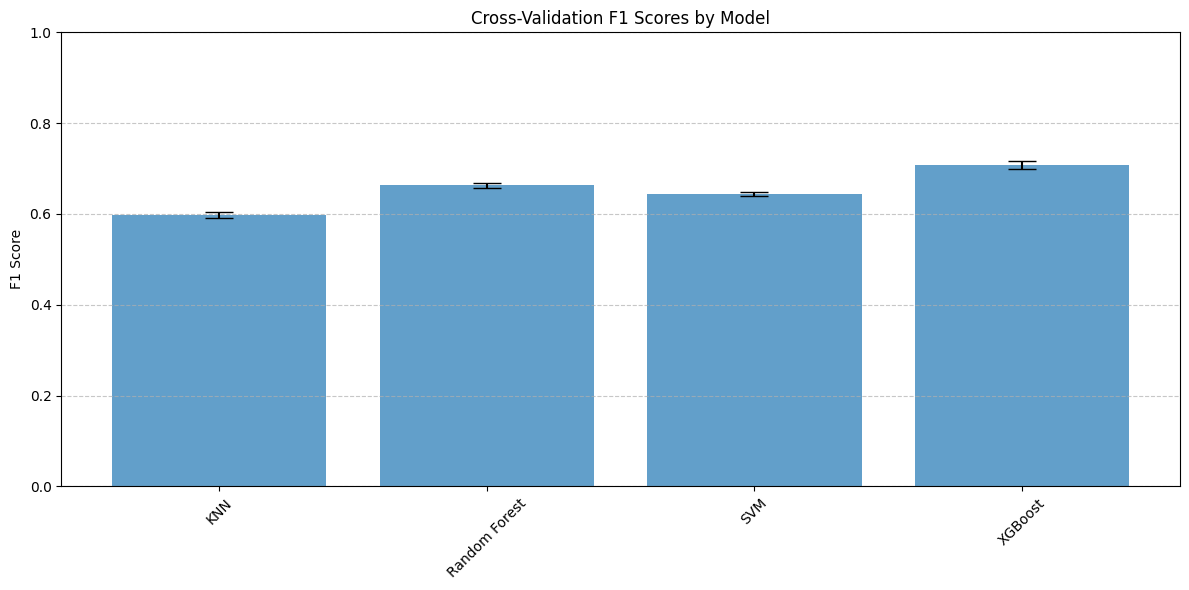

In [54]:
# Cross-validation for model comparison
print("\n--- Model Evaluation with Cross-Validation ---")
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numeric for cross-validation
# XGBoost requires numeric labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # '<=50K' becomes 0, '>50K' becomes 1

# Dictionary of best models
best_models = {
    'KNN': knn_opt,
    'Random Forest': rf_opt,
    'SVM': svm_opt,
    'XGBoost': xgb_opt
}

# Create a DataFrame to store results
cv_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])

# Perform 5-fold cross-validation for each model
for name, model in best_models.items():
    print(f"\nEvaluating {name} with 5-fold cross-validation...")
    
    try:
        # Calculate metrics with cross-validation using encoded labels
        accuracy = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5, scoring='accuracy')
        f1 = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5, scoring='f1')
        precision = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5, scoring='precision')
        recall = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5, scoring='recall')
        
        # Add results to DataFrame
        cv_results = pd.concat([cv_results, pd.DataFrame({
            'Model': [name],
            'Accuracy': [f"{accuracy.mean():.3f} ± {accuracy.std():.3f}"],
            'F1 Score': [f"{f1.mean():.3f} ± {f1.std():.3f}"],
            'Precision': [f"{precision.mean():.3f} ± {precision.std():.3f}"],
            'Recall': [f"{recall.mean():.3f} ± {recall.std():.3f}"]
        })], ignore_index=True)
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        print(f"Skipping {name} in cross-validation.")

# Display cross-validation results
print("\n--- Cross-Validation Results ---")
print(cv_results)

# Create a bar plot comparing F1 scores
plt.figure(figsize=(12, 6))
models = cv_results['Model']
f1_means = [float(x.split('±')[0]) for x in cv_results['F1 Score']]
f1_errors = [float(x.split('±')[1]) for x in cv_results['F1 Score']]

plt.bar(models, f1_means, yerr=f1_errors, capsize=10, alpha=0.7)
plt.title('Cross-Validation F1 Scores by Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


--- SHAP Explanation for Model Interpretability ---
Generating SHAP Summary Plot...


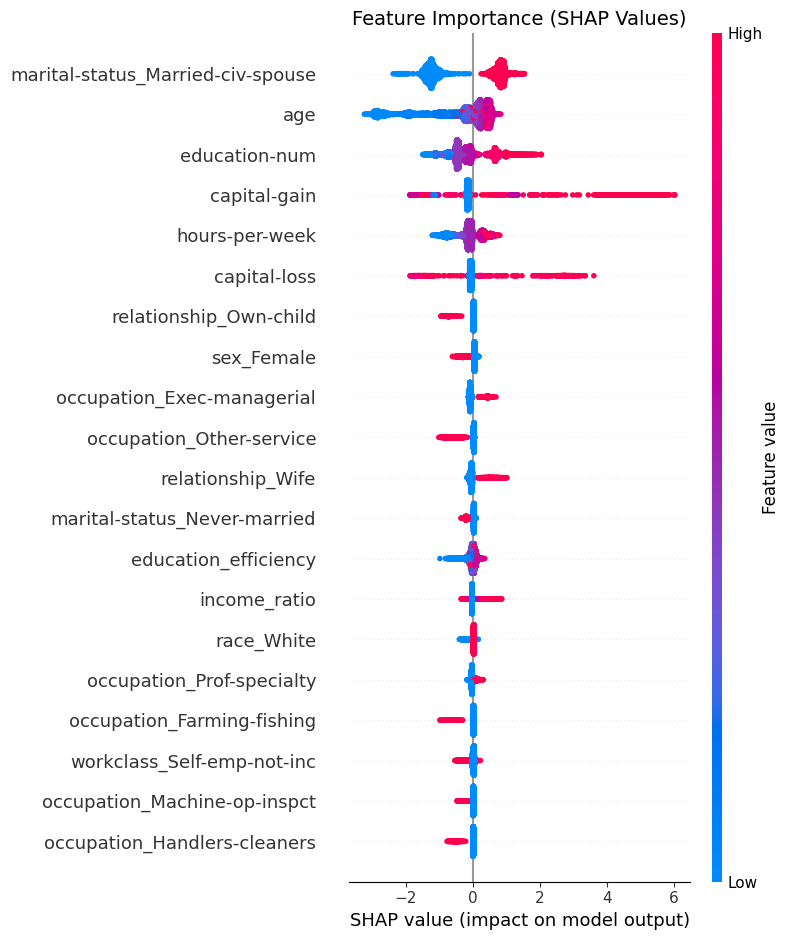

Generating SHAP Dependence Plots for key features...


<Figure size 1000x700 with 0 Axes>

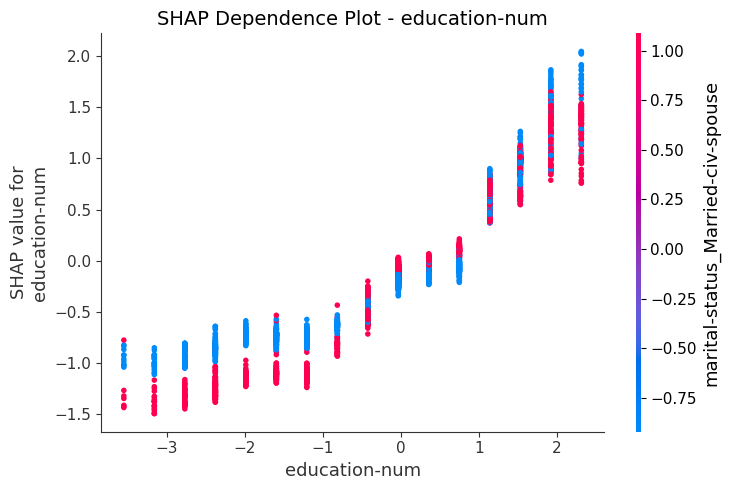

<Figure size 1000x700 with 0 Axes>

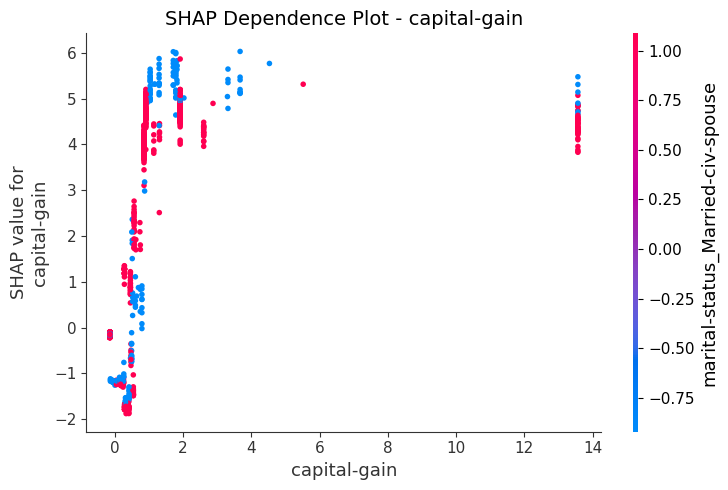

<Figure size 1000x700 with 0 Axes>

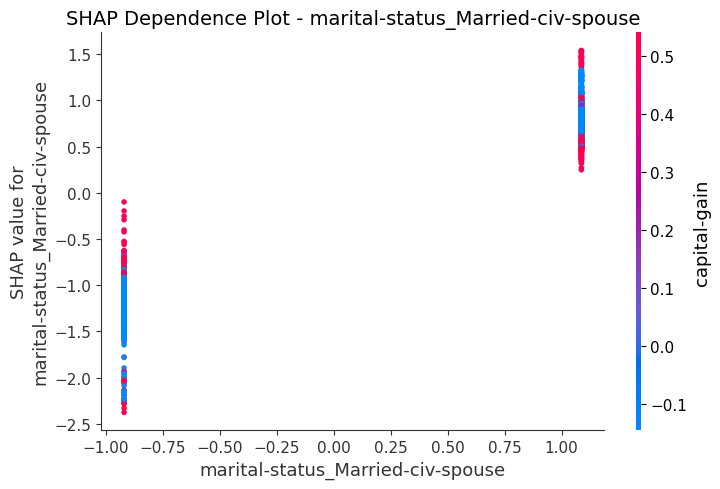

<Figure size 1000x700 with 0 Axes>

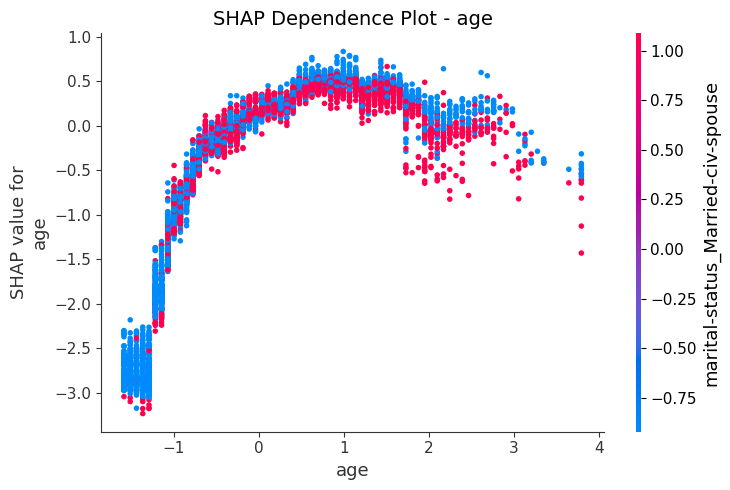

<Figure size 1000x700 with 0 Axes>

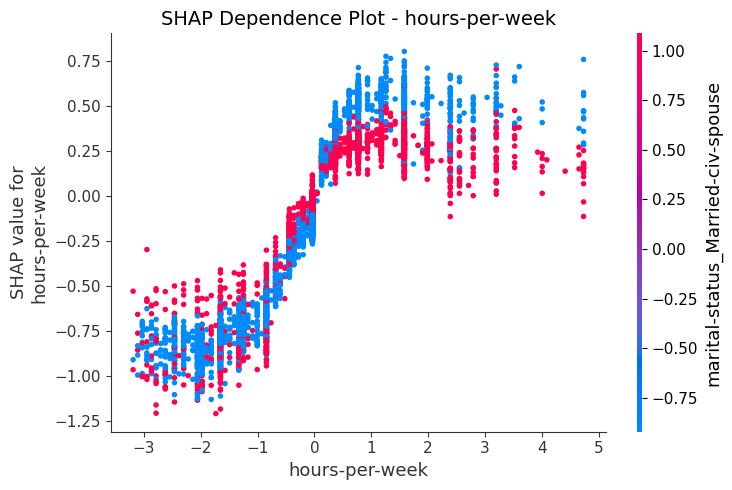

In [55]:
# SHAP Explanation
print("\n--- SHAP Explanation for Model Interpretability ---")
import shap

# Define the important features to analyze
top_features = ['education-num', 'capital-gain', 'marital-status_Married-civ-spouse', 
                'age', 'hours-per-week']

# Use the best-performing model
best_model = xgb_opt  # Ensure best_model is defined

try:
    # Create explainer with proper handling for XGBoost
    if isinstance(best_model, xgb.XGBClassifier):
        explainer = shap.TreeExplainer(best_model.get_booster())
    else:
        explainer = shap.TreeExplainer(best_model)
    
    # Get SHAP values
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Handle different output formats from different models
    if isinstance(shap_values, list) and len(shap_values) > 1:
        # For multi-class output, use the positive class (index 1)
        plot_shap_values = shap_values[1]
        base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
    else:
        # For single array output (binary classification in XGBoost)
        plot_shap_values = shap_values
        base_value = explainer.expected_value
    
    # SHAP Summary Plot
    print("Generating SHAP Summary Plot...")
    plt.figure(figsize=(14, 10))
    shap.summary_plot(plot_shap_values, X_test_scaled, feature_names=X_test_scaled.columns, show=False)
    plt.title('Feature Importance (SHAP Values)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # SHAP Dependence Plots for important features
    print("Generating SHAP Dependence Plots for key features...")
    for feature in top_features:
        if feature in X_test_scaled.columns:
            plt.figure(figsize=(10, 7))
            shap.dependence_plot(
                feature, plot_shap_values, X_test_scaled,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature}', fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Feature '{feature}' not found in dataset columns")
    
except Exception as e:
    print(f"Error in SHAP visualization: {str(e)}")
    import traceback
    traceback.print_exc()

In [56]:
# LIME explanation for individual predictions
import lime
import lime.lime_tabular

In [57]:
# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled.values, 
    feature_names=X_train_scaled.columns,
    class_names=['>50K', '<=50K'],
    mode='classification'
)

In [58]:
# Get explanation for an instance
instance_idx = 5
exp = explainer.explain_instance(
    X_test_scaled.iloc[instance_idx].values, 
    best_model.predict_proba, 
    num_features=10
)

<Figure size 1200x800 with 0 Axes>

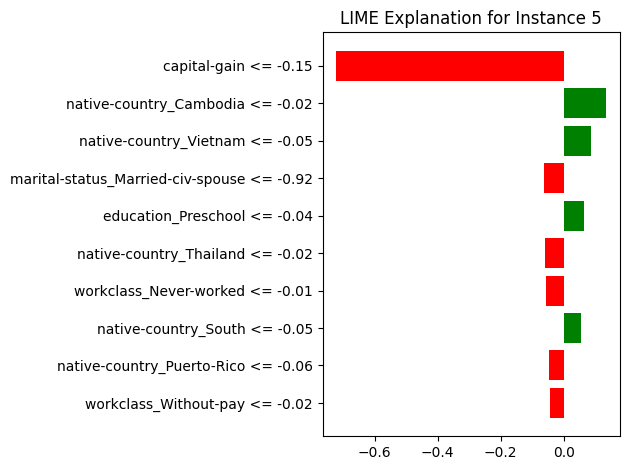

In [59]:
# Plot LIME explanation
plt.figure(figsize=(12, 8))
exp.as_pyplot_figure()
plt.title(f'LIME Explanation for Instance {instance_idx}')
plt.tight_layout()
plt.show()

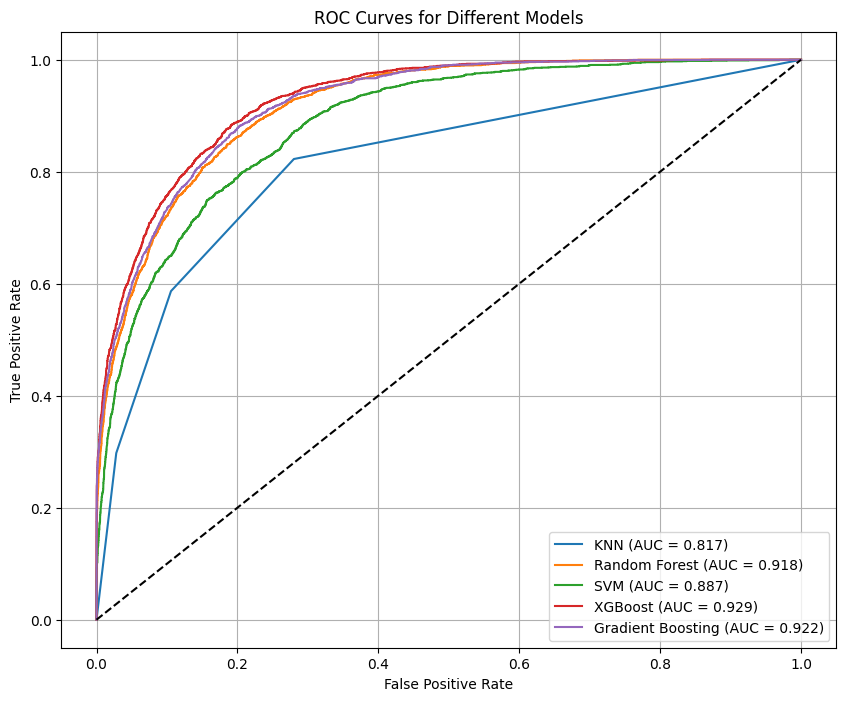

In [60]:
# ROC curves and AUC for the best models
plt.figure(figsize=(10, 8))
models = {
    'KNN': knn_opt,
    'Random Forest': rf_opt,
    'SVM': svm_opt,
    'XGBoost': xgb_opt,
    'Gradient Boosting': gb
}

from sklearn import metrics as sklearn_metrics  # Using a different name to avoid conflict

for name, model in models.items():
    y_pred_proba = None
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For SVM without probability estimation
        y_pred_proba = model.decision_function(X_test_scaled)
    
    fpr, tpr, _ = sklearn_metrics.roc_curve(y_test == '>50K', y_pred_proba)
    auc = sklearn_metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
# Final prediction on the provided test set
print("\n--- Final Predictions on Test Set ---")
# Use the best model for final prediction
best_model = xgb_opt # Change based on performance results
y_pred_final = best_model.predict(X_test_final_scaled)


--- Final Predictions on Test Set ---


In [62]:

# Evaluate final predictions
from sklearn import metrics as sklearn_metrics  # Import with different name to avoid conflict

# Convert y_pred_final back to string labels
y_pred_final_labels = label_encoder.inverse_transform(y_pred_final)

print('Final Test Set Performance:')
print('Accuracy:', round(sklearn_metrics.accuracy_score(y_test_final, y_pred_final_labels), 3))
print('F1 Score:', round(sklearn_metrics.f1_score(y_test_final, y_pred_final_labels, pos_label='>50K'), 3))
print(sklearn_metrics.classification_report(y_test_final, y_pred_final_labels))

Final Test Set Performance:
Accuracy: 0.871
F1 Score: 0.7
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92     12435
        >50K       0.78      0.64      0.70      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.79      0.81     16281
weighted avg       0.87      0.87      0.87     16281



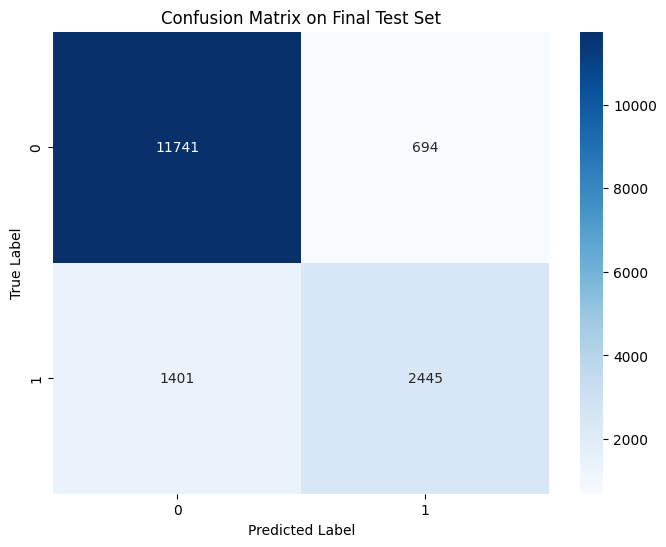

In [63]:
# Confusion Matrix
from sklearn import metrics as sklearn_metrics  # Import metrics from sklearn with different name to avoid conflict

plt.figure(figsize=(8, 6))
# Convert y_pred_final to string labels
y_pred_final_labels = label_encoder.inverse_transform(y_pred_final)

# Compute confusion matrix
cm = sklearn_metrics.confusion_matrix(y_test_final, y_pred_final_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Final Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Reloading datasets from original files...
Training data shape: (32561, 14)
Test data shape: (16281, 14)

--- Checking for ? values ---
Column workclass has 1836 '?' values
Column occupation has 1843 '?' values
Column native-country has 583 '?' values
Column workclass has 963 '?' values
Column occupation has 966 '?' values
Column native-country has 274 '?' values

--- Replacing ? with NaN ---

--- After fixing ? values ---
Training data missing values:
                sum_missing
workclass              1836
occupation             1843
native-country          583

Test data missing values:
                sum_missing
workclass               963
occupation              966
native-country          274

--- Imputing missing values ---
Imputed missing values in workclass with 'Private'
Imputed missing values in occupation with 'Prof-specialty'
Imputed missing values in native-country with 'United-States'

--- After imputation ---
Any missing values in training data: False
Any missing values 

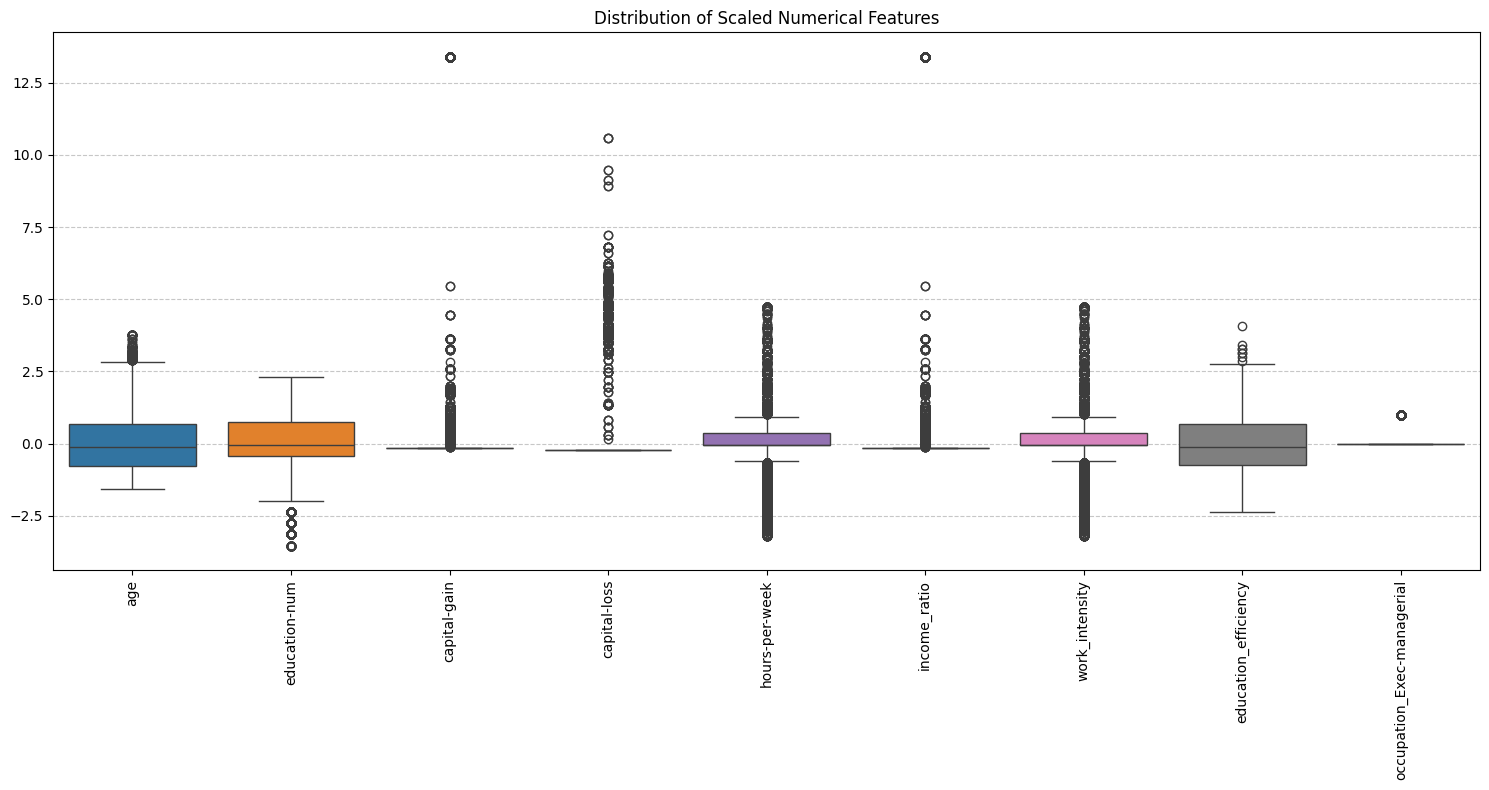

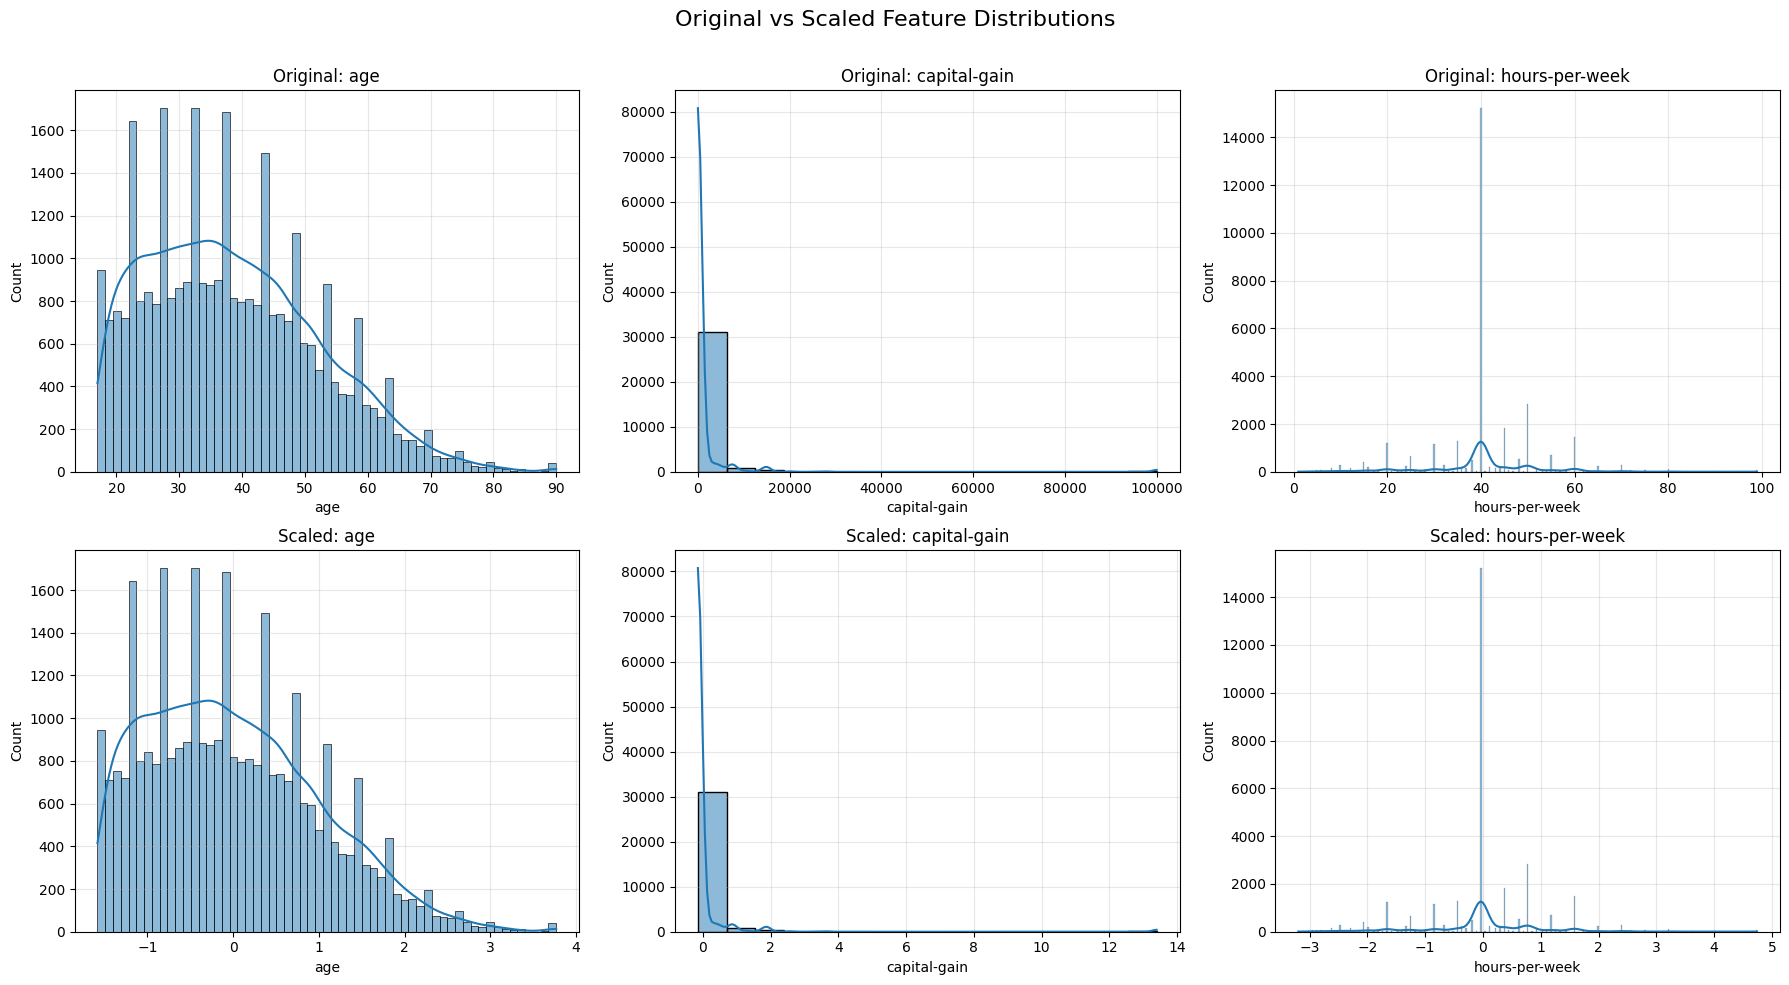

Class weights: {'<=50K': np.float64(0.6585962783171521), '>50K': np.float64(2.0763295498023213)}
XGBoost scale_pos_weight: 3.15


In [64]:
# Reload all data from original files with fixes for the preprocessing issue
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import sparse

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option("display.precision", 2)
warnings.filterwarnings('ignore')

print("Reloading datasets from original files...")

# Define column names
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Load datasets
train_data_path = 'adult.data'
test_data_path = 'adult.test'

train_data = pd.read_csv(train_data_path, header=None, names=column_names,
                        na_values=' ?', skipinitialspace=True)
test_data = pd.read_csv(test_data_path, header=None, names=column_names,
                       na_values=' ?', skipinitialspace=True, skiprows=1)


# Fix target format in test data (remove dot)
test_data['income'] = test_data['income'].str.replace('.', '')

# Remove fnlwgt column
train_data = train_data.drop('fnlwgt', axis=1)
test_data = test_data.drop('fnlwgt', axis=1)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Check for ? characters in the dataset 
print("\n--- Checking for ? values ---")
for col in train_data.select_dtypes(include=['object']).columns:
    q_count = (train_data[col] == ' ?').sum() + (train_data[col] == '?').sum()
    if q_count > 0:
        print(f"Column {col} has {q_count} '?' values")

for col in test_data.select_dtypes(include=['object']).columns:
    q_count = (test_data[col] == ' ?').sum() + (test_data[col] == '?').sum()
    if q_count > 0:
        print(f"Column {col} has {q_count} '?' values")

# Replace ? and ' ?' with NaN in all object columns
print("\n--- Replacing ? with NaN ---")
for dataset in [train_data, test_data]:
    for col in dataset.select_dtypes(include=['object']).columns:
        # Replace both formats of question mark with NaN
        dataset[col] = dataset[col].replace(['?', ' ?'], np.nan)

# Verify the fix
print("\n--- After fixing ? values ---")
missing_train = pd.DataFrame({'sum_missing': train_data.isnull().sum()})
missing_test = pd.DataFrame({'sum_missing': test_data.isnull().sum()})
print("Training data missing values:")
print(missing_train[missing_train['sum_missing'] > 0])
print("\nTest data missing values:")
print(missing_test[missing_test['sum_missing'] > 0])

# Basic preprocessing for categorical variables
for dataset in [train_data, test_data]:
    # Remove leading/trailing spaces
    for col in dataset.select_dtypes(include=['object']).columns:
        dataset[col] = dataset[col].str.strip()
        
# Impute missing values before splitting
print("\n--- Imputing missing values ---")
# For categorical features - impute with most frequent value
for col in train_data.select_dtypes(include=['object']).columns:
    if train_data[col].isnull().sum() > 0:
        most_frequent = train_data[col].mode()[0]
        train_data[col].fillna(most_frequent, inplace=True)
        test_data[col].fillna(most_frequent, inplace=True)
        print(f"Imputed missing values in {col} with '{most_frequent}'")

# For numerical features - impute with median
for col in train_data.select_dtypes(include=['number']).columns:
    if train_data[col].isnull().sum() > 0:
        median_value = train_data[col].median()
        train_data[col].fillna(median_value, inplace=True)
        test_data[col].fillna(median_value, inplace=True)
        print(f"Imputed missing values in {col} with median: {median_value}")

# Verify all missing values are handled
print("\n--- After imputation ---")
print("Any missing values in training data:", train_data.isnull().any().any())
print("Any missing values in test data:", test_data.isnull().any().any())


# Use all of adult.data as training set
X_train = train_data.drop('income', axis=1)
y_train = train_data['income']

# Use adult.test as the test set
X_test = test_data.drop('income', axis=1)
y_test = test_data['income']

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Class distribution in training: {y_train.value_counts(normalize=True)}")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Class distribution in training: {y_train.value_counts(normalize=True)}")

# Get categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {len(categorical_cols)}")
print(f"Numerical features: {len(numerical_cols)}")

# Get categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {len(categorical_cols)}")
print(f"Numerical features: {len(numerical_cols)}")

# Add engineered features to X_train and X_test
# Create a feature for income-related factors
X_train['income_ratio'] = X_train['capital-gain'] / (X_train['capital-loss'] + 1)
X_test['income_ratio'] = X_test['capital-gain'] / (X_test['capital-loss'] + 1)

# Create work-status feature
X_train['work_intensity'] = X_train['hours-per-week'] / 40
X_test['work_intensity'] = X_test['hours-per-week'] / 40

# Create education to age ratio (education efficiency)
X_train['education_efficiency'] = X_train['education-num'] / X_train['age']
X_test['education_efficiency'] = X_test['education-num'] / X_test['age']

# Update numerical_cols to include these new features
numerical_cols = numerical_cols + ['income_ratio', 'work_intensity', 'education_efficiency']

# === FIXED PREPROCESSING CODE ===
# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    verbose_feature_names_out=False)



# Fit and transform with appropriate output format
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Check if output is sparse and convert to dense if needed
if sparse.issparse(X_train_preprocessed):
    X_train_preprocessed = X_train_preprocessed.toarray()
    X_test_preprocessed = X_test_preprocessed.toarray()

# Get feature names properly
feature_names = preprocessor.get_feature_names_out()
print(f"Number of features after preprocessing: {len(feature_names)}")
print(f"Preprocessed data shape: {X_train_preprocessed.shape}")

# Create DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_preprocessed, columns=feature_names)

print(f"Data preprocessing completed. X_train_scaled shape: {X_train_scaled.shape}")


# Visualize the scaled numerical features
plt.figure(figsize=(15, 8))
# Plot a subset of features if there are too many
scaled_numerical_cols = [col for col in X_train_scaled.columns if any(num_col in col for num_col in numerical_cols)]
scaled_sample = X_train_scaled[scaled_numerical_cols[:10]]  # First 10 numerical features

# Boxplot of scaled features
sns.boxplot(data=scaled_sample)
plt.title('Distribution of Scaled Numerical Features')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compare original vs scaled distribution for a few key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Original vs Scaled Feature Distributions', fontsize=16)

# Select a few important numerical features
key_features = ['age', 'capital-gain', 'hours-per-week']
for i, feature in enumerate(key_features):
    # Original distribution
    sns.histplot(X_train[feature], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'Original: {feature}')
    axes[0, i].grid(True, alpha=0.3)
    
    # Scaled distribution
    scaled_feature = f'num__{feature}' if f'num__{feature}' in X_train_scaled.columns else feature
    sns.histplot(X_train_scaled[scaled_feature], kde=True, ax=axes[1, i])
    axes[1, i].set_title(f'Scaled: {scaled_feature}')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Label encoding for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Calculate class weights
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train), 
                                   y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class weights:", class_weight_dict)

# For XGBoost
pos_weight = len(y_train[y_train == '<=50K']) / len(y_train[y_train == '>50K'])
print(f"XGBoost scale_pos_weight: {pos_weight:.2f}")


--- Balanced Models with Feature Optimization ---
Training Random Forest with feature optimization...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': None, 'feature_selection__threshold': 'mean'}
Training XGBoost with feature optimization...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost parameters: {'model__subsample': 0.9, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.8, 'feature_selection__threshold': '0.5*mean'}

--- Evaluating Optimized Models ---
Random Forest metrics:
Accuracy: 0.835
F1 Score: 0.691

XGBoost metrics:
Accuracy: 0.831
F1 Score: 0.706

Number of features selected by Random Forest: 18
Number of features selected by XGBoost: 30


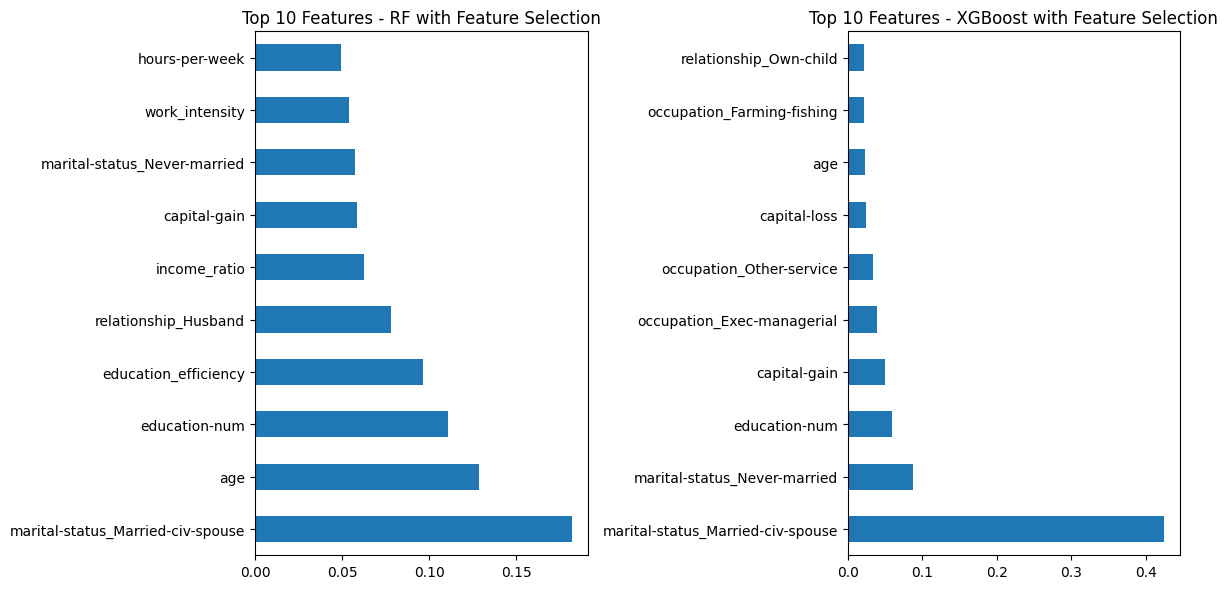

In [65]:
# Import feature selection tools
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import numpy as np

print("\n--- Balanced Models with Feature Optimization ---")

# 1. Random Forest with Feature Optimization
rf_pipe = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

rf_param_grid = {
    'feature_selection__threshold': ['mean', 'median', '0.5*mean', '1.25*mean'],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30, None],
    'model__max_features': ['sqrt', 'log2'],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

rf_opt_search = RandomizedSearchCV(
    rf_pipe, param_distributions=rf_param_grid,
    n_iter=20, cv=5, scoring='f1', verbose=1, random_state=42
)

print("Training Random Forest with feature optimization...")
rf_opt_search.fit(X_train_scaled, y_train)
rf_opt_pipe = rf_opt_search.best_estimator_
print("Best Random Forest parameters:", rf_opt_search.best_params_)

# 2. XGBoost with Feature Optimization
xgb_pipe = Pipeline([
    ('feature_selection', SelectFromModel(xgb.XGBClassifier(random_state=42))),
    ('model', xgb.XGBClassifier(scale_pos_weight=pos_weight, random_state=42))
])

xgb_param_grid = {
    'feature_selection__threshold': ['mean', 'median', '0.5*mean', '1.25*mean'],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_opt_search = RandomizedSearchCV(
    xgb_pipe, param_distributions=xgb_param_grid,
    n_iter=20, cv=5, scoring='f1', verbose=1, random_state=42
)

print("Training XGBoost with feature optimization...")
xgb_opt_search.fit(X_train_scaled, y_train_encoded)
xgb_opt_pipe = xgb_opt_search.best_estimator_
print("Best XGBoost parameters:", xgb_opt_search.best_params_)

# Evaluate optimized models
print("\n--- Evaluating Optimized Models ---")
# Random Forest predictions
y_pred_rf_opt = rf_opt_pipe.predict(X_test_scaled)
print('Random Forest metrics:')
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred_rf_opt), 3))
print('F1 Score:', round(metrics.f1_score(y_test, y_pred_rf_opt, pos_label='>50K'), 3))

# XGBoost predictions
y_pred_xgb_opt_encoded = xgb_opt_pipe.predict(X_test_scaled)
y_pred_xgb_opt = label_encoder.inverse_transform(y_pred_xgb_opt_encoded)
print('\nXGBoost metrics:')
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred_xgb_opt), 3))
print('F1 Score:', round(metrics.f1_score(y_test, y_pred_xgb_opt, pos_label='>50K'), 3))

# Selected features visualization
rf_selected_features = rf_opt_pipe.named_steps['feature_selection'].get_support()
xgb_selected_features = xgb_opt_pipe.named_steps['feature_selection'].get_support()

print(f"\nNumber of features selected by Random Forest: {np.sum(rf_selected_features)}")
print(f"Number of features selected by XGBoost: {np.sum(xgb_selected_features)}")

# Visualize top features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
rf_importance = pd.Series(
    rf_opt_pipe.named_steps['model'].feature_importances_,
    index=np.array(X_train_scaled.columns)[rf_selected_features]
).sort_values(ascending=False)
rf_importance.head(10).plot(kind='barh')
plt.title('Top 10 Features - RF with Feature Selection')
plt.tight_layout()

plt.subplot(1, 2, 2)
try:
    xgb_importance = pd.Series(
        xgb_opt_pipe.named_steps['model'].feature_importances_,
        index=np.array(X_train_scaled.columns)[xgb_selected_features]
    ).sort_values(ascending=False)
    xgb_importance.head(10).plot(kind='barh')
    plt.title('Top 10 Features - XGBoost with Feature Selection')
except:
    print("Could not visualize XGBoost feature importances")
plt.tight_layout()
plt.show()

In [66]:
# Add necessary imports for gradient boosting
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Check if clf_results exists, if not create it
try:
    clf_results
except NameError:
    clf_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall'])
    
# Gradient Boosting Hyperparameter Tuning
print("\n--- Gradient Boosting Hyperparameter Tuning ---")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                           gb_param_grid, 
                           n_iter=20,
                           cv=5, 
                           scoring='f1',
                           verbose=1,
                           random_state=42)

gb_grid.fit(X_train_scaled, y_train)
print("Best Gradient Boosting parameters:", gb_grid.best_params_)

gb_opt = gb_grid.best_estimator_
y_pred_gb_opt = gb_opt.predict(X_test_scaled)

print('Accuracy for Optimized Gradient Boosting:', round(metrics.accuracy_score(y_test, y_pred_gb_opt), 3))
print('F1 Score for Optimized Gradient Boosting:', round(metrics.f1_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3))
print(metrics.classification_report(y_test, y_pred_gb_opt))

clf_results = pd.concat([clf_results, pd.DataFrame({
    'Model': ['Optimized Gradient Boosting'],
    'Accuracy': [round(metrics.accuracy_score(y_test, y_pred_gb_opt), 3)],
    'F1': [round(metrics.f1_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3)],
    'Precision': [round(metrics.precision_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3)],
    'Recall': [round(metrics.recall_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3)]
})])


--- Gradient Boosting Hyperparameter Tuning ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Gradient Boosting parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.2}
Accuracy for Optimized Gradient Boosting: 0.867
F1 Score for Optimized Gradient Boosting: 0.696
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91     12435
        >50K       0.76      0.64      0.70      3846

    accuracy                           0.87     16281
   macro avg       0.83      0.79      0.81     16281
weighted avg       0.86      0.87      0.86     16281




--- Class-Balanced Models Comparison ---
                         Model  Accuracy    F1  Precision  Recall
0     Random Forest (Balanced)      0.83  0.69       0.62    0.78
1           XGBoost (Balanced)      0.83  0.71       0.60    0.86
2  Optimized Gradient Boosting      0.87  0.70       0.76    0.64


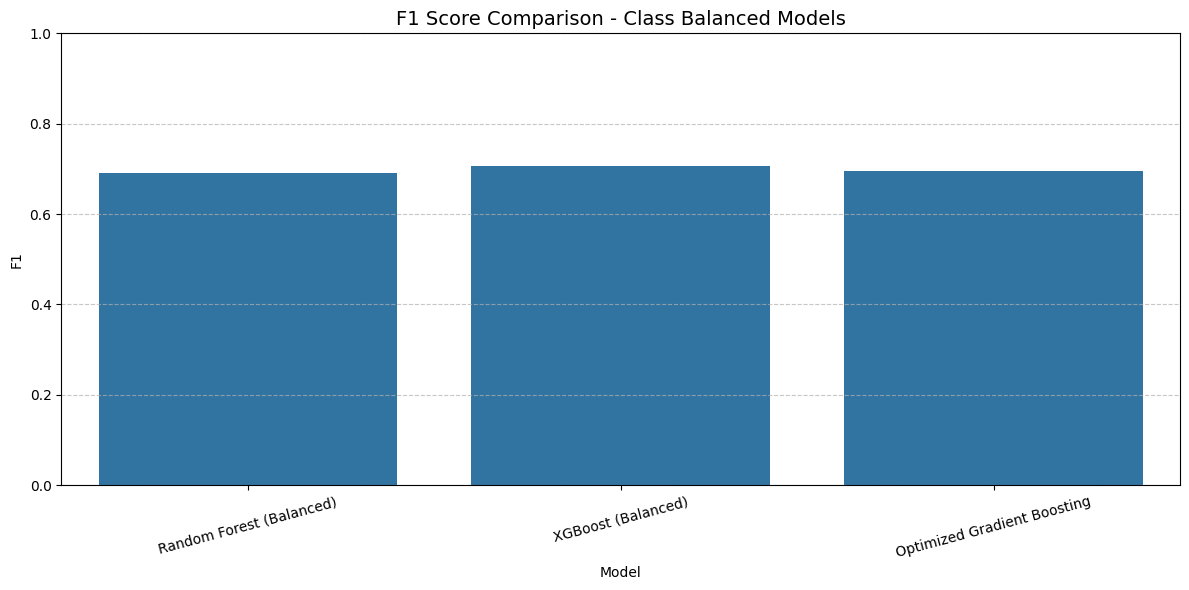

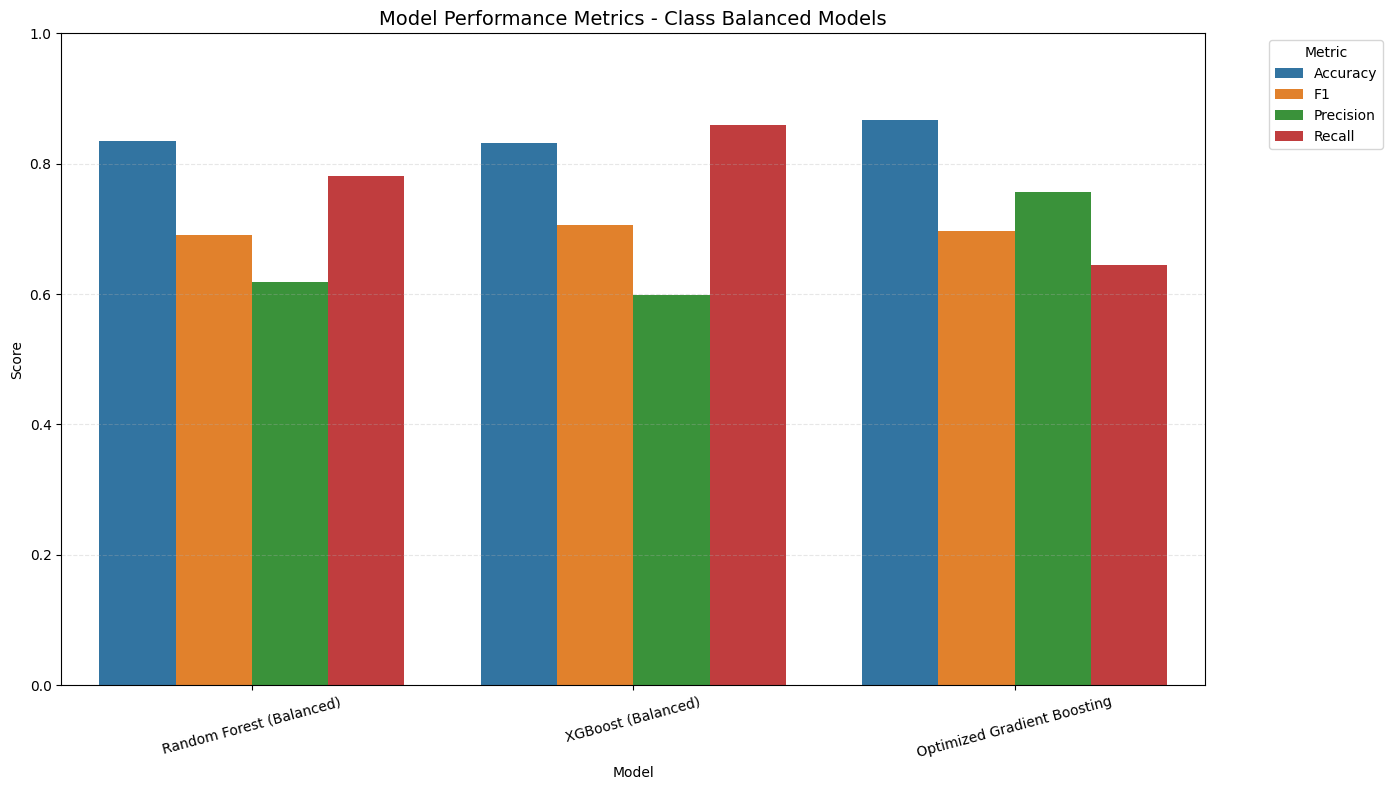

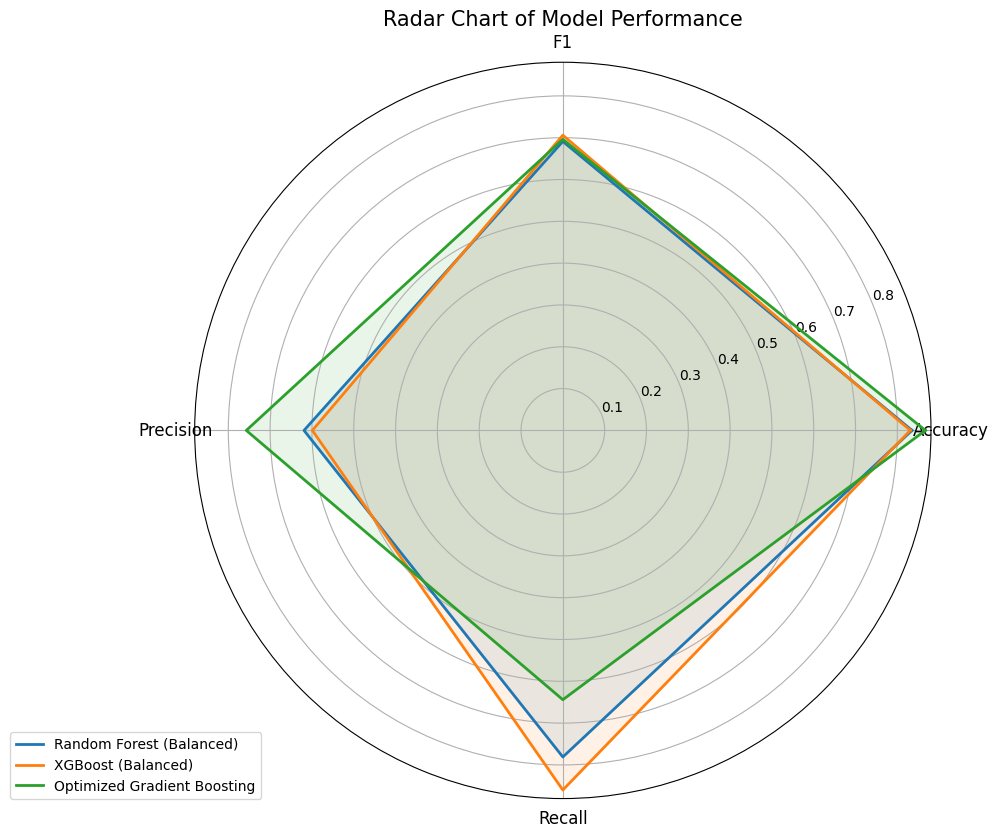

In [67]:
# First, generate predictions from the balanced models
y_pred_rf_balanced = rf_opt_pipe.predict(X_test_scaled)
y_pred_xgb_balanced_encoded = xgb_opt_pipe.predict(X_test_scaled)
y_pred_xgb_balanced = label_encoder.inverse_transform(y_pred_xgb_balanced_encoded)

# Collect results from the class-balanced models and gradient boosting
balanced_results = pd.DataFrame([
    {
        'Model': 'Random Forest (Balanced)',
        'Accuracy': round(metrics.accuracy_score(y_test, y_pred_rf_balanced), 3),
        'F1': round(metrics.f1_score(y_test, y_pred_rf_balanced, pos_label='>50K'), 3),
        'Precision': round(metrics.precision_score(y_test, y_pred_rf_balanced, pos_label='>50K'), 3),
        'Recall': round(metrics.recall_score(y_test, y_pred_rf_balanced, pos_label='>50K'), 3)
    },
    {
        'Model': 'XGBoost (Balanced)',
        'Accuracy': round(metrics.accuracy_score(y_test, y_pred_xgb_balanced), 3),
        'F1': round(metrics.f1_score(y_test, y_pred_xgb_balanced, pos_label='>50K'), 3),
        'Precision': round(metrics.precision_score(y_test, y_pred_xgb_balanced, pos_label='>50K'), 3),
        'Recall': round(metrics.recall_score(y_test, y_pred_xgb_balanced, pos_label='>50K'), 3)
    },
    {
        'Model': 'Optimized Gradient Boosting',
        'Accuracy': round(metrics.accuracy_score(y_test, y_pred_gb_opt), 3),
        'F1': round(metrics.f1_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3),
        'Precision': round(metrics.precision_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3),
        'Recall': round(metrics.recall_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3)
    }
])

# Print the tabular comparison
print("\n--- Class-Balanced Models Comparison ---")
print(balanced_results)

# Create bar plot comparing F1 scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1', data=balanced_results)
plt.title('F1 Score Comparison - Class Balanced Models', fontsize=14)
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a comprehensive comparison of all metrics
plt.figure(figsize=(14, 8))
metrics_to_plot = ['Accuracy', 'F1', 'Precision', 'Recall']
balanced_results_melted = pd.melt(balanced_results, id_vars=['Model'], 
                                 value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=balanced_results_melted)
plt.title('Model Performance Metrics - Class Balanced Models', fontsize=14)
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Create a radar chart for a different visualization perspective
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_chart(df, metrics):
    # Number of variables
    categories = df['Model'].tolist()
    N = len(metrics)
    
    # Create a figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], metrics, size=12)
    
    # Draw the chart for each model
    for i, model in enumerate(categories):
        values = df.loc[i, metrics].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Radar Chart of Model Performance', size=15)
    
    return fig, ax

# Prepare data for radar chart
radar_metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
radar_fig, radar_ax = radar_chart(balanced_results, radar_metrics)
plt.tight_layout()
plt.show()


--- SHAP Explanation for Balanced XGBoost ---


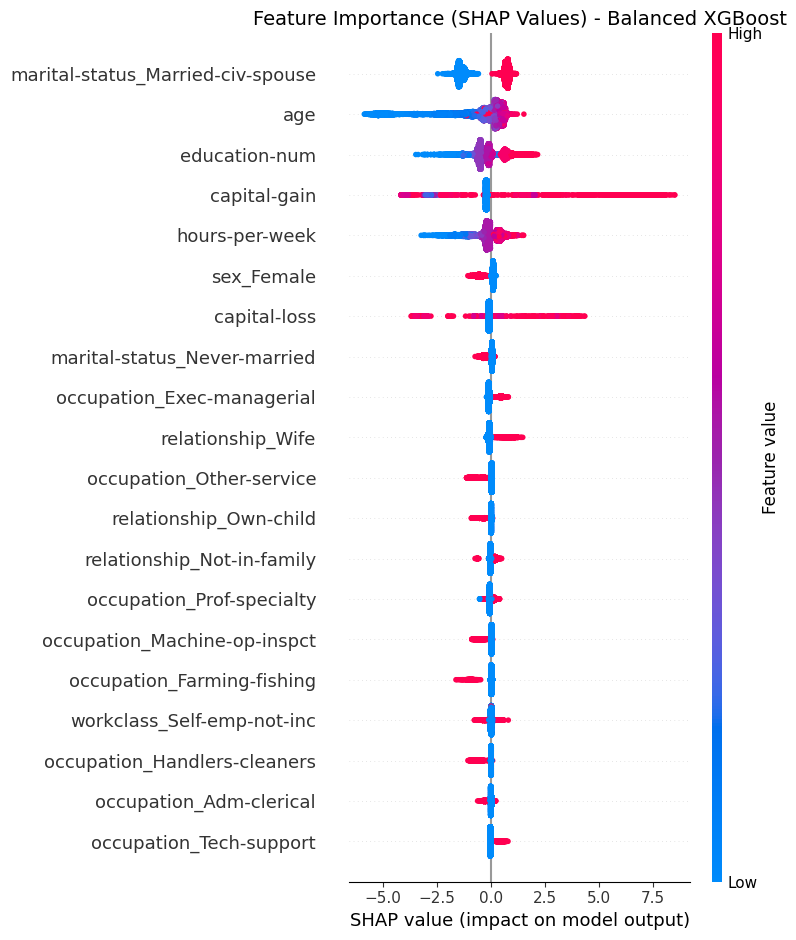

<Figure size 1000x700 with 0 Axes>

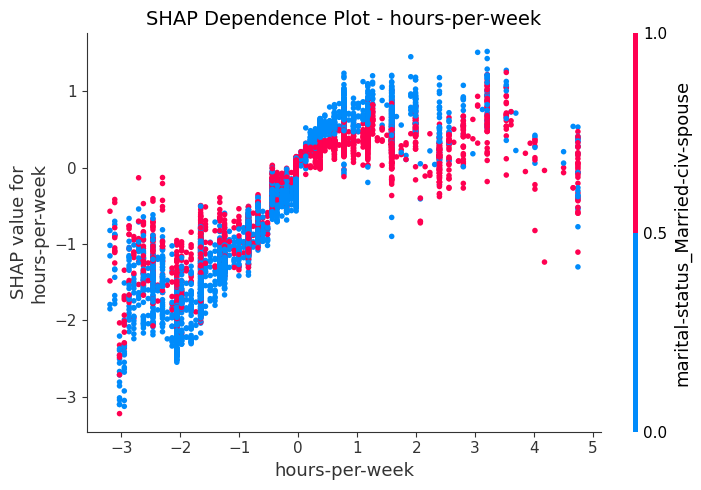

<Figure size 1000x700 with 0 Axes>

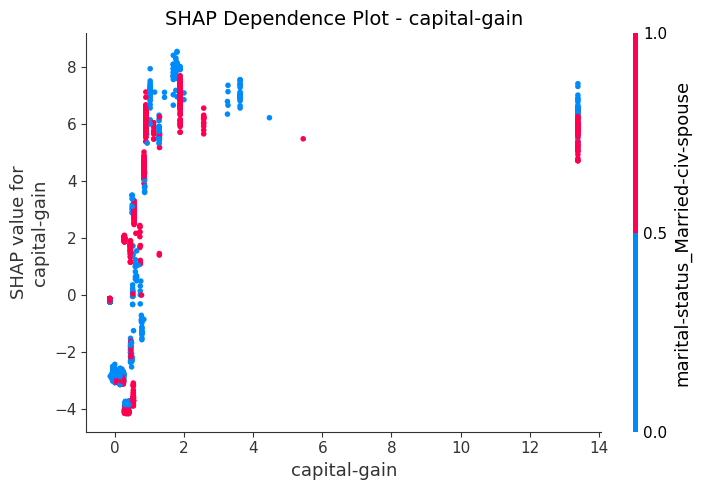

<Figure size 1000x700 with 0 Axes>

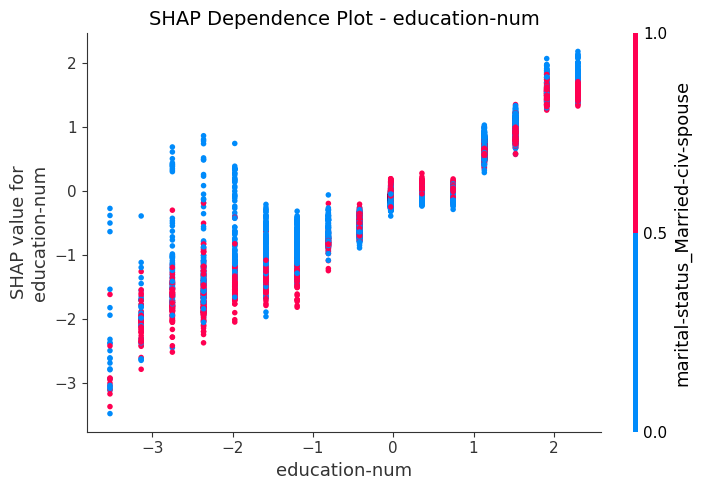

<Figure size 1000x700 with 0 Axes>

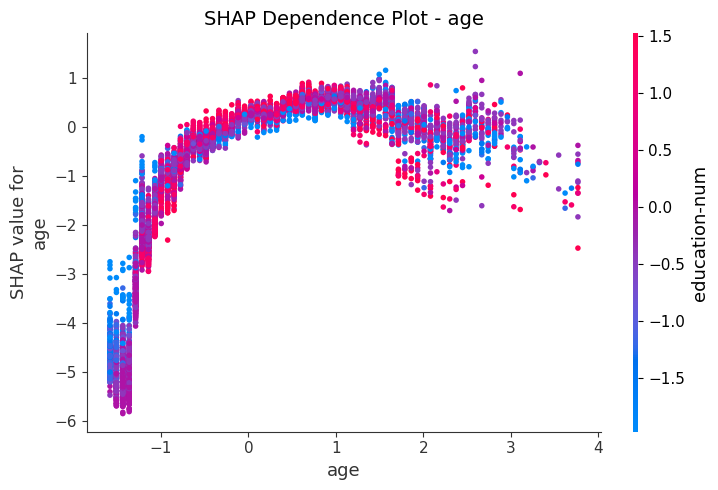

<Figure size 1000x700 with 0 Axes>

In [68]:
# Fix for SHAP with XGBoost pipeline
print("\n--- SHAP Explanation for Balanced XGBoost ---")
import shap

# Get the mask of selected features
selected_features_mask = xgb_opt_pipe.named_steps['feature_selection'].get_support()

# Get selected feature names
selected_feature_names = X_train_scaled.columns[selected_features_mask]

# Apply feature selection to get the right subset of features
X_test_selected = X_test_scaled.loc[:, selected_features_mask]

# Use the XGBoost model from the pipeline
balanced_model = xgb_opt_pipe.named_steps['model']

try:
    # Create SHAP explainer
    explainer = shap.TreeExplainer(balanced_model)
    
    # Get SHAP values using only the selected features
    shap_values = explainer.shap_values(X_test_selected)
    
    # Handle different output formats from XGBoost
    if isinstance(shap_values, list) and len(shap_values) > 1:
        # For multi-class output
        plot_shap_values = shap_values[1]
    else:
        # For binary classification
        plot_shap_values = shap_values
    
    # SHAP Summary Plot
    plt.figure(figsize=(14, 10))
    shap.summary_plot(
        plot_shap_values, 
        X_test_selected,
        feature_names=selected_feature_names,
        show=False
    )
    plt.title('Feature Importance (SHAP Values) - Balanced XGBoost', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # SHAP Dependence plots for top features (if they were selected)
    num_features_to_plot = min(5, len(selected_feature_names))
    feature_importance = np.abs(plot_shap_values).mean(axis=0)
    top_indices = feature_importance.argsort()[-num_features_to_plot:]
    
    for i in top_indices:
        feature = selected_feature_names[i]
        plt.figure(figsize=(10, 7))
        shap.dependence_plot(
            i, plot_shap_values, X_test_selected,
            feature_names=selected_feature_names,
            show=False
        )
        plt.title(f'SHAP Dependence Plot - {feature}', fontsize=14)
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error in SHAP visualization: {str(e)}")
    import traceback
    traceback.print_exc()

In [69]:
#  LIME explanation with XGBoost pipeline
print("\n--- LIME Explanation for Balanced XGBoost (Fixed) ---")
import lime
import lime.lime_tabular

# Get the selected features 
selected_features_mask = xgb_opt_pipe.named_steps['feature_selection'].get_support()
selected_feature_names = X_train_scaled.columns[selected_features_mask]

# Get training and test data with only selected features
X_train_selected = X_train_scaled.loc[:, selected_features_mask]
X_test_selected = X_test_scaled.loc[:, selected_features_mask]

# Create LIME explainer with only the selected features
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_selected.values,
    feature_names=selected_feature_names,
    class_names=['>50K', '<=50K'],
    mode='classification'
)

# Get explanation for instance
instance_idx = 5
exp = explainer.explain_instance(
    X_test_selected.iloc[instance_idx].values,
    balanced_model.predict_proba,
    num_features=min(10, len(selected_feature_names))
)

# Plot LIME explanation
plt.figure(figsize=(12, 8))
exp.as_pyplot_figure()
plt.title(f'LIME Explanation for Instance {instance_idx} - Balanced XGBoost')
plt.tight_layout()
plt.show()


--- LIME Explanation for Balanced XGBoost (Fixed) ---


<Figure size 1200x800 with 0 Axes>

Optimal threshold: 0.653
At this threshold - Precision: 0.691, Recall: 0.763, F1: 0.726

--- XGBoost with Optimal Threshold ---
              precision    recall  f1-score   support

       <=50K       0.92      0.89      0.91     12435
        >50K       0.69      0.76      0.73      3846

    accuracy                           0.86     16281
   macro avg       0.81      0.83      0.82     16281
weighted avg       0.87      0.86      0.87     16281



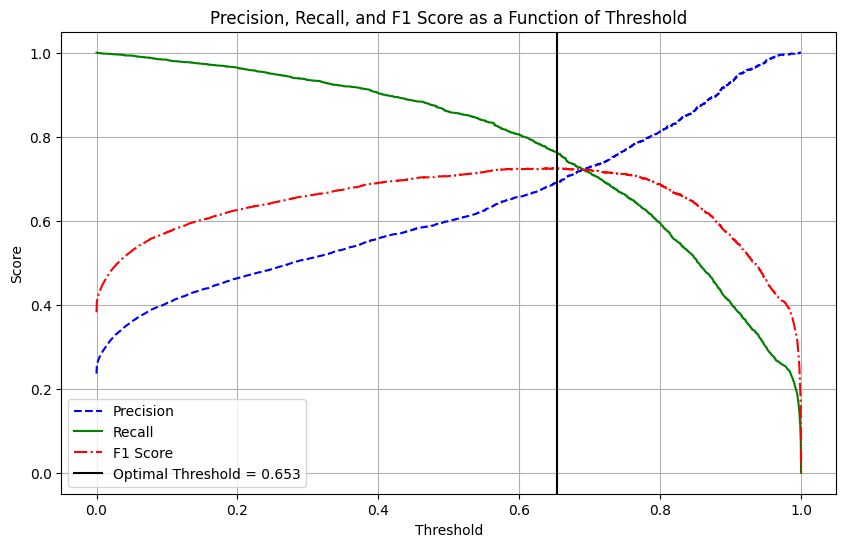

In [70]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, classification_report
import numpy as np

# Threshold adjustment for XGBoost predictions
import matplotlib.pyplot as plt

# Get predicted probabilities for XGBoost
# We need to use the pipeline to transform our data
X_test_selected = xgb_opt_pipe.named_steps['feature_selection'].transform(X_test_scaled)
y_proba_xgb = xgb_opt_pipe.named_steps['model'].predict_proba(X_test_selected)

# For binary classification, we take the probability of positive class
y_proba_xgb_positive = y_proba_xgb[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_encoded, y_proba_xgb_positive)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, lw=2, label=f'PR curve (area = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Find optimal threshold that maximizes F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"At this threshold - Precision: {precision[optimal_idx]:.3f}, Recall: {recall[optimal_idx]:.3f}, F1: {f1_scores[optimal_idx]:.3f}")

# Apply the optimal threshold to get new predictions
y_pred_xgb_optimal = (y_proba_xgb_positive >= optimal_threshold).astype(int)
y_pred_xgb_optimal_labels = label_encoder.inverse_transform(y_pred_xgb_optimal)

# Evaluate new predictions
print("\n--- XGBoost with Optimal Threshold ---")
print(classification_report(y_test, y_pred_xgb_optimal_labels))

# Plot ROC curve as well
fpr, tpr, _ = roc_curve(y_test_encoded, y_proba_xgb_positive)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot showing precision, recall, and F1 as functions of threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r-.', label='F1 Score')
plt.axvline(x=optimal_threshold, color='k', linestyle='-', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score as a Function of Threshold')
plt.legend()
plt.grid(True)
plt.show()


--- Final Model Comparison with Optimal Threshold XGBoost ---
                         Model  Accuracy    F1  Precision  Recall
0     Random Forest (Balanced)      0.83  0.69       0.62    0.78
1           XGBoost (Balanced)      0.83  0.71       0.60    0.86
2  Optimized Gradient Boosting      0.87  0.70       0.76    0.64
3  XGBoost (Optimal Threshold)      0.86  0.73       0.69    0.76


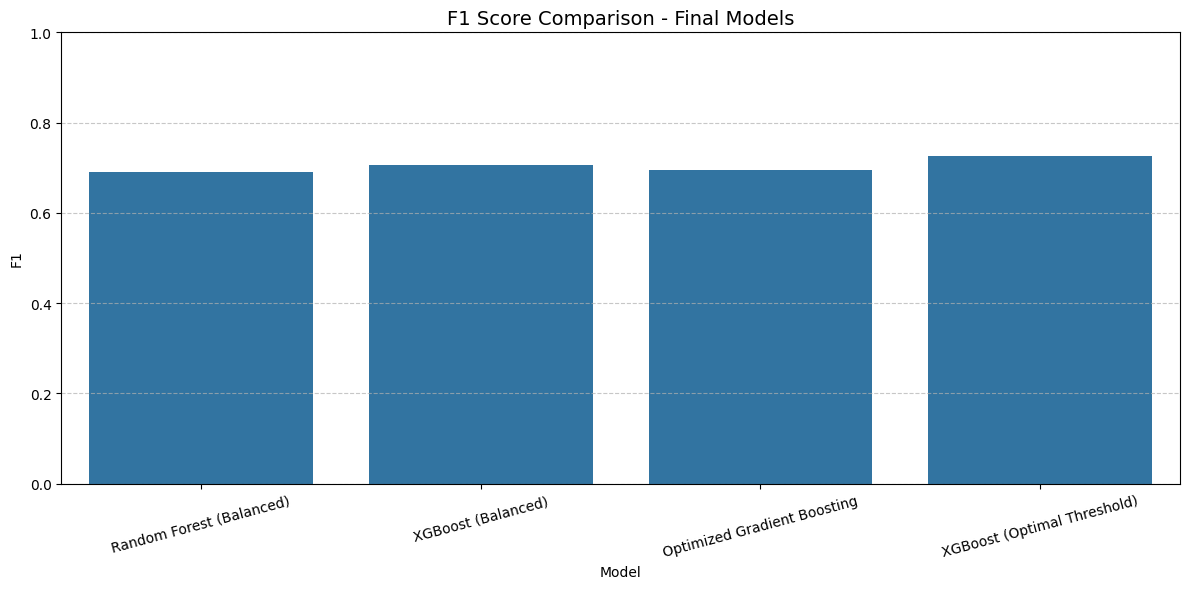

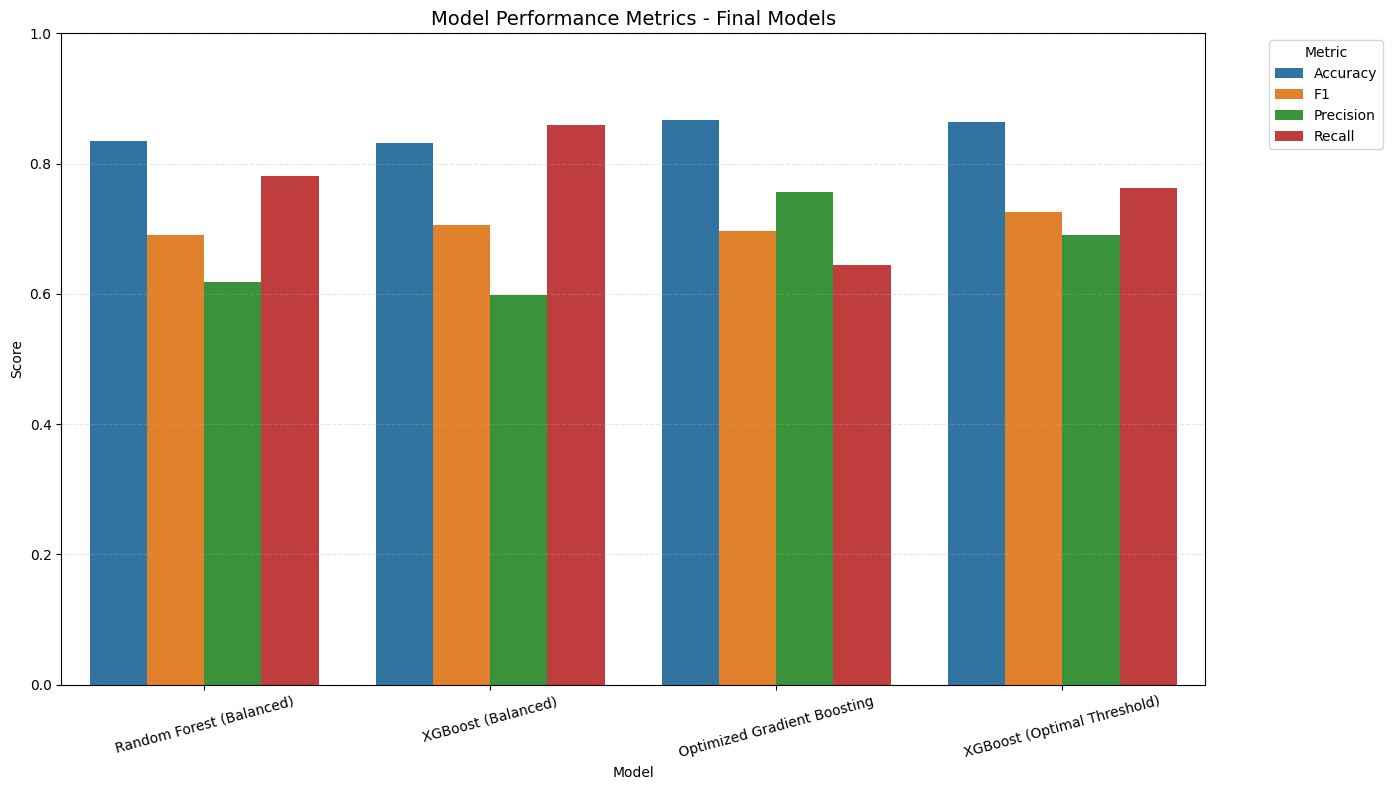

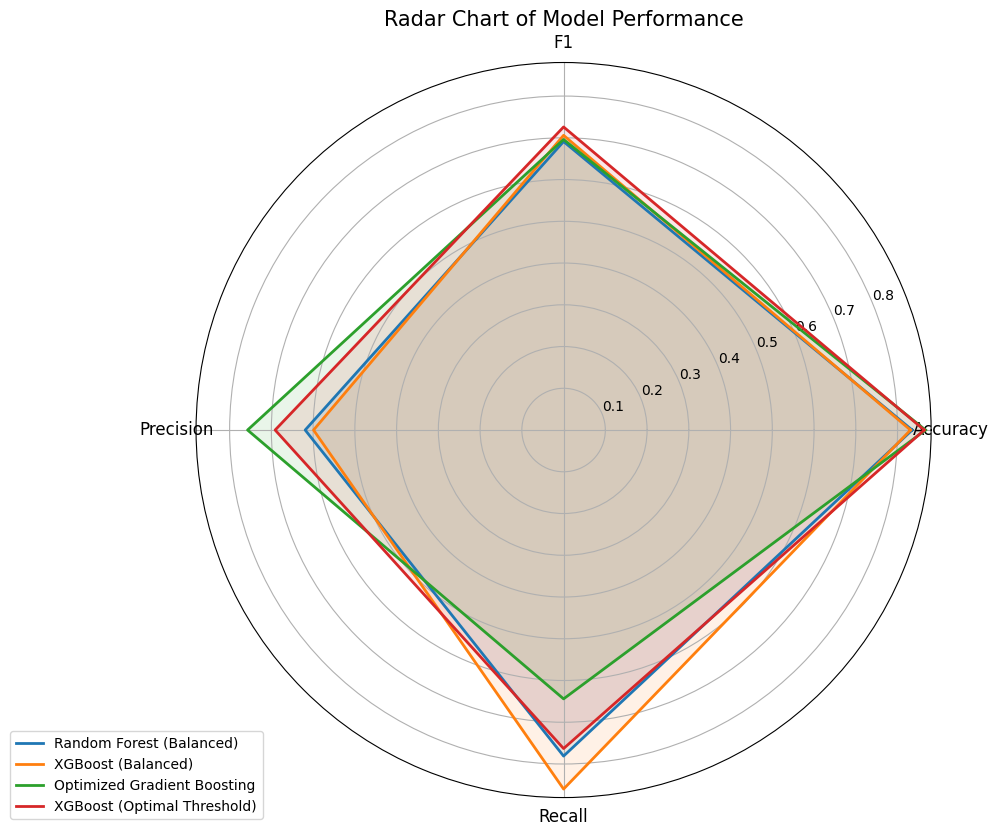

In [71]:
# Collect metrics for XGBoost with optimal threshold 
# and add to the comparison with other models
xgb_optimal_results = {
    'Model': 'XGBoost (Optimal Threshold)',
    'Accuracy': round(metrics.accuracy_score(y_test, y_pred_xgb_optimal_labels), 3),
    'F1': round(metrics.f1_score(y_test, y_pred_xgb_optimal_labels, pos_label='>50K'), 3),
    'Precision': round(metrics.precision_score(y_test, y_pred_xgb_optimal_labels, pos_label='>50K'), 3),
    'Recall': round(metrics.recall_score(y_test, y_pred_xgb_optimal_labels, pos_label='>50K'), 3)
}

# Combine with previous model results
all_model_results = pd.DataFrame([
    {
        'Model': 'Random Forest (Balanced)',
        'Accuracy': round(metrics.accuracy_score(y_test, y_pred_rf_balanced), 3),
        'F1': round(metrics.f1_score(y_test, y_pred_rf_balanced, pos_label='>50K'), 3),
        'Precision': round(metrics.precision_score(y_test, y_pred_rf_balanced, pos_label='>50K'), 3),
        'Recall': round(metrics.recall_score(y_test, y_pred_rf_balanced, pos_label='>50K'), 3)
    },
    {
        'Model': 'XGBoost (Balanced)',
        'Accuracy': round(metrics.accuracy_score(y_test, y_pred_xgb_balanced), 3),
        'F1': round(metrics.f1_score(y_test, y_pred_xgb_balanced, pos_label='>50K'), 3),
        'Precision': round(metrics.precision_score(y_test, y_pred_xgb_balanced, pos_label='>50K'), 3),
        'Recall': round(metrics.recall_score(y_test, y_pred_xgb_balanced, pos_label='>50K'), 3)
    },
    {
        'Model': 'Optimized Gradient Boosting',
        'Accuracy': round(metrics.accuracy_score(y_test, y_pred_gb_opt), 3),
        'F1': round(metrics.f1_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3),
        'Precision': round(metrics.precision_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3),
        'Recall': round(metrics.recall_score(y_test, y_pred_gb_opt, pos_label='>50K'), 3)
    },
    xgb_optimal_results
])

# Print the tabular comparison
print("\n--- Final Model Comparison with Optimal Threshold XGBoost ---")
print(all_model_results)

# Create bar plot comparing F1 scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1', data=all_model_results)
plt.title('F1 Score Comparison - Final Models', fontsize=14)
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a comprehensive comparison of all metrics
plt.figure(figsize=(14, 8))
metrics_to_plot = ['Accuracy', 'F1', 'Precision', 'Recall']
all_results_melted = pd.melt(all_model_results, id_vars=['Model'], 
                             value_vars=metrics_to_plot,
                             var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=all_results_melted)
plt.title('Model Performance Metrics - Final Models', fontsize=14)
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Radar chart for visual comparison
def radar_chart(df, metrics):
    # Number of variables
    categories = df['Model'].tolist()
    N = len(metrics)
    
    # Create a figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], metrics, size=12)
    
    # Draw the chart for each model
    for i, model in enumerate(categories):
        values = df.loc[i, metrics].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Radar Chart of Model Performance', size=15)
    
    return fig, ax

# Prepare data for radar chart
radar_metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
radar_fig, radar_ax = radar_chart(all_model_results, radar_metrics)
plt.tight_layout()
plt.show()


--- SHAP Explanation for Optimal Threshold XGBoost ---


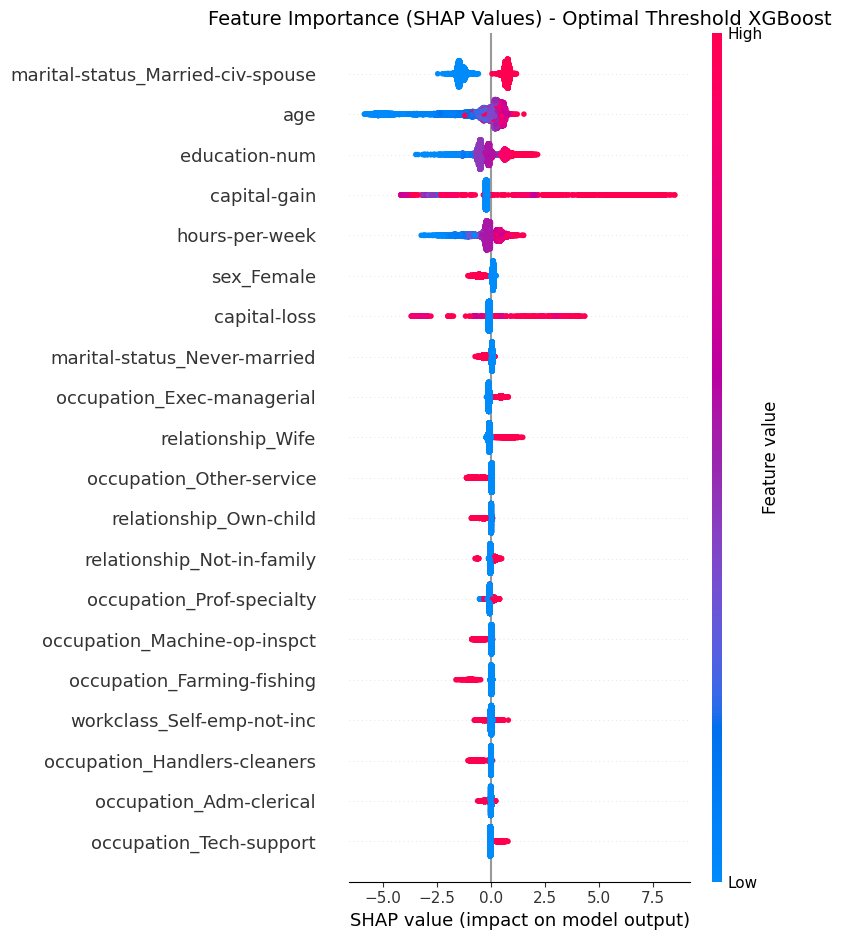

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

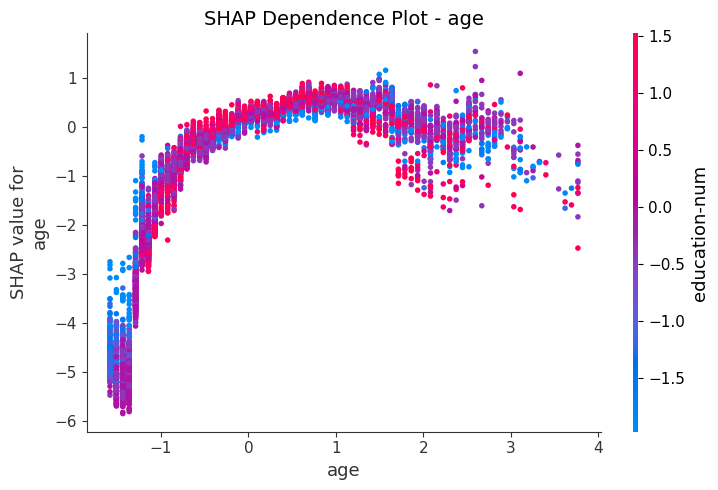

<Figure size 1000x700 with 0 Axes>

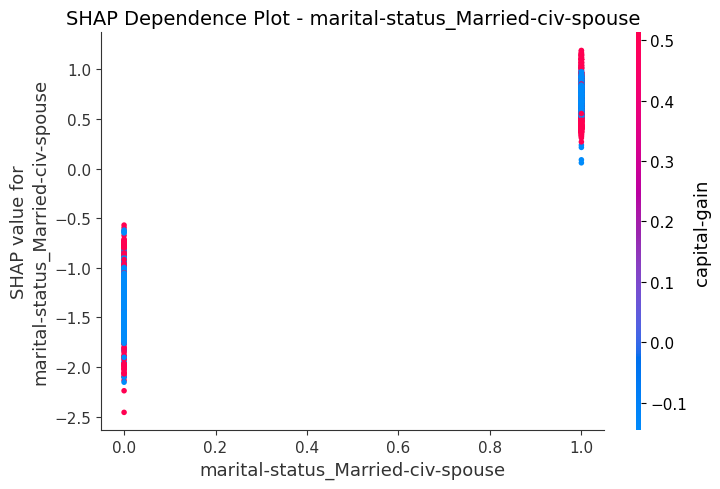


--- LIME Explanation for Optimal Threshold XGBoost ---


<Figure size 1200x800 with 0 Axes>

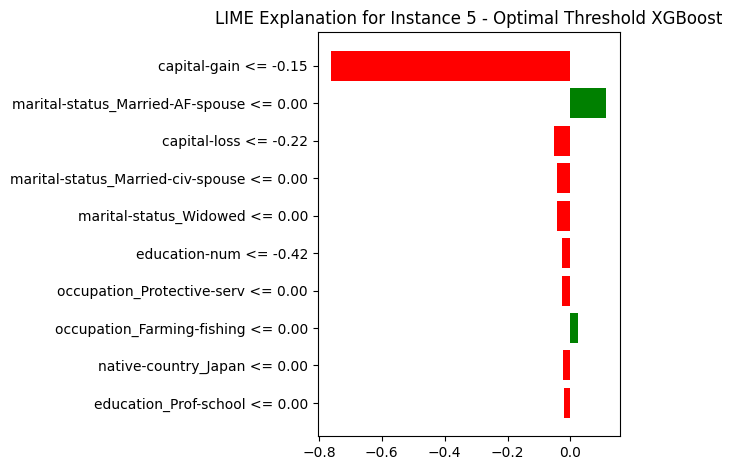

In [72]:
import shap
import traceback
import lime

# SHAP Explanation for Optimal Threshold XGBoost
print("\n--- SHAP Explanation for Optimal Threshold XGBoost ---")

# Get the selected features
selected_features_mask = xgb_opt_pipe.named_steps['feature_selection'].get_support()
selected_feature_names = X_train_scaled.columns[selected_features_mask]

# Apply feature selection to get the right subset of features
X_test_selected = X_test_scaled.loc[:, selected_features_mask]

# Use the XGBoost model from the pipeline
optimal_model = xgb_opt_pipe.named_steps['model']

try:
    # Create SHAP explainer
    explainer = shap.TreeExplainer(optimal_model)
    
    # Get SHAP values using only the selected features
    shap_values = explainer.shap_values(X_test_selected)
    
    # Handle different output formats from XGBoost
    if isinstance(shap_values, list) and len(shap_values) > 1:
        # For multi-class output
        plot_shap_values = shap_values[1]
    else:
        # For binary classification
        plot_shap_values = shap_values
    
    # SHAP Summary Plot
    plt.figure(figsize=(14, 10))
    shap.summary_plot(
        plot_shap_values, 
        X_test_selected,
        feature_names=selected_feature_names,
        show=False
    )
    plt.title('Feature Importance (SHAP Values) - Optimal Threshold XGBoost', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # SHAP Dependence plots for top features (if they were selected)
    num_features_to_plot = min(5, len(selected_feature_names))
    feature_importance = np.abs(plot_shap_values).mean(axis=0)
    top_indices = feature_importance.argsort()[-num_features_to_plot:]
    
    for i in top_indices:
        feature = selected_feature_names[i]
        plt.figure(figsize=(10, 7))
        shap.dependence_plot(
            i, plot_shap_values, X_test_selected,
            feature_names=selected_feature_names,
            show=False
        )
        plt.title(f'SHAP Dependence Plot - {feature}', fontsize=14)
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error in SHAP visualization: {str(e)}")
    traceback.print_exc()

# LIME Explanation for Optimal Threshold XGBoost
print("\n--- LIME Explanation for Optimal Threshold XGBoost ---")
import lime.lime_tabular

# Create LIME explainer with only the selected features
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_selected.values,
    feature_names=selected_feature_names,
    class_names=['>50K', '<=50K'],
    mode='classification'
)

# Get explanation for instance
instance_idx = 5
exp = explainer.explain_instance(
    X_test_selected.iloc[instance_idx].values,
    optimal_model.predict_proba,
    num_features=min(10, len(selected_feature_names))
)

# Plot LIME explanation
plt.figure(figsize=(12, 8))
exp.as_pyplot_figure()
plt.title(f'LIME Explanation for Instance {instance_idx} - Optimal Threshold XGBoost')
plt.tight_layout()
plt.show()